In [2]:
import sys

#The problem is that this was added to path. something fucked with my conda_init file.
#So now we just need to put it at the bottom of the path like so and our issues is fixed.
sys.path.remove('/people/enge625/.local/lib/python3.9/site-packages')
sys.path.append('/people/enge625/.local/lib/python3.9/site-packages')

sys.path.append('/people/enge625/src/easy_ntk/')

import numpy as np
import torch
import random

import matplotlib.pyplot as plt


import torch
from torch import nn, optim
from torch import load
from torch.nn import functional as F
from torch import autograd

from torchvision import datasets

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

import time

import sys
from pathlib import Path

#from numba import njit

import os

import gc

from tqdm import tqdm

#from easyntk.explicit import explicit_ntk

In [3]:
import pandas as pd
# because the dataset is int tsv format we have to use delimeter.
df = pd.read_csv("../cola_public/raw/in_domain_train.tsv", delimiter='\t', header=None, names=['sentence_sources', 'label', 'label_note', 'sentence'])

# creating a copy so we don't messed up our original dataset.
data=df.copy()
data.head(10)

sentence_sources  label label_note  \
0             gj04      1        NaN   
1             gj04      1        NaN   
2             gj04      1        NaN   
3             gj04      1        NaN   
4             gj04      1        NaN   
5             gj04      1        NaN   
6             gj04      1        NaN   
7             gj04      1        NaN   
8             gj04      1        NaN   
9             gj04      1        NaN   

                                            sentence  
0  Our friends won't buy this analysis, let alone...  
1  One more pseudo generalization and I'm giving up.  
2   One more pseudo generalization or I'm giving up.  
3     The more we study verbs, the crazier they get.  
4          Day by day the facts are getting murkier.  
5                              I'll fix you a drink.  
6                      Fred watered the plants flat.  
7        Bill coughed his way out of the restaurant.  
8                      We're dancing the night away.  
9                    Herman hammered the metal flat.

In [4]:
data.drop(['sentence_sources','label_note'],axis=1,inplace=True)
sentences=data.sentence.values
labels = data.label.values
data.head()

label                                           sentence
0      1  Our friends won't buy this analysis, let alone...
1      1  One more pseudo generalization and I'm giving up.
2      1   One more pseudo generalization or I'm giving up.
3      1     The more we study verbs, the crazier they get.
4      1          Day by day the facts are getting murkier.

In [5]:
from transformers import BertTokenizer
# using the low level BERT for our task.
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Printing the original sentence.
print(' Original: ', sentences[0])

# Printing the tokenized sentence in form of list.
print('Tokenized: ', tokenizer.tokenize(sentences[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

 Original:  Our friends won't buy this analysis, let alone the next one we propose.
Tokenized:  ['our', 'friends', 'won', "'", 't', 'buy', 'this', 'analysis', ',', 'let', 'alone', 'the', 'next', 'one', 'we', 'propose', '.']
Token IDs:  [2256, 2814, 2180, 1005, 1056, 4965, 2023, 4106, 1010, 2292, 2894, 1996, 2279, 2028, 2057, 16599, 1012]


In [6]:
input_ids = []
for sent in sentences:
    # so basically encode tokenizing , mapping sentences to thier token ids after adding special tokens.
    encoded_sent = tokenizer.encode(
                        sent,                      # Sentence which are encoding.
                        add_special_tokens = True, # Adding special tokens '[CLS]' and '[SEP]'

                         )
    
 
    input_ids.append(encoded_sent)

In [7]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

MAX_LEN = 128

input_ids = pad_sequences(input_ids, maxlen=MAX_LEN , truncating="post", padding="post")

2023-09-07 12:06:56.392068: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-07 12:06:58.137750: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [8]:
attention_masks = []

for sent in input_ids:
    
    # Generating attention mask for sentences.
    #   - when there is 0 present as token id we are going to set mask as 0.
    #   - we are going to set mask 1 for all non-zero positive input id.
    att_mask = [int(token_id > 0) for token_id in sent]
    
   
    attention_masks.append(att_mask)

In [9]:
from sklearn.model_selection import train_test_split

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, test_size=0.2, random_state=0)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels,test_size=0.2, random_state=0)

In [10]:
len(train_inputs)

6840

In [11]:
#changing the numpy arrays into tensors for working on GPU. 
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Deciding the batch size for training.

batch_size = 32

#DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = SequentialSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size, shuffle=False)

In [12]:
# pathprefix = '/rcfs/projects/task0_pmml/BERT/one_gpu_development/testDDP_additivecomponents_seed3/'
# for i,file in enumerate(os.listdir(pathprefix)):
#     if i ==0:
#         NTK = torch.load(os.path.join(pathprefix,file))[0:8192,0:8192]
#     else:
#         NTK += torch.load(os.path.join(pathprefix,file))[0:8192,0:8192]
# torch.save(NTK,os.path.join('/rcfs/projects/task0_pmml/BERT/one_gpu_development/NTKs','NTK_seed3.pt'))

In [13]:
NTK_seedless = torch.load(os.path.join('/rcfs/projects/task0_pmml/BERT/one_gpu_development/NTKs','NTK_seedless.pt')).cpu().numpy()
NTK_seed1 = torch.load(os.path.join('/rcfs/projects/task0_pmml/BERT/one_gpu_development/NTKs','NTK_seed1.pt')).cpu().numpy()
NTK_seed2 = torch.load(os.path.join('/rcfs/projects/task0_pmml/BERT/one_gpu_development/NTKs','NTK_seed2.pt')).cpu().numpy()
NTK_seed3 = torch.load(os.path.join('/rcfs/projects/task0_pmml/BERT/one_gpu_development/NTKs','NTK_seed3.pt')).cpu().numpy()

In [14]:
# CK_seedless = 
# CK_seed1 = 
# CK_seed2 = 
# CK_seed3 = 

In [15]:
N_test_DATAPOINTS = len(NTK_seed1) - len(train_inputs)

# DataLoader for our validation(test) set.
validation_data = TensorDataset(validation_inputs[0:N_test_DATAPOINTS], validation_masks[0:N_test_DATAPOINTS], validation_labels[0:N_test_DATAPOINTS])
validation_labels = validation_labels[0:N_test_DATAPOINTS]
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size, shuffle=False)

In [16]:
N_test_DATAPOINTS

1352

In [17]:
def calculate_COSSIM(NTK,train_data_index=len(train_inputs)):
    K0 =NTK[0:train_data_index,0:train_data_index] #this is the train data gram matrix
    K1 = NTK[train_data_index::,0:train_data_index] #this is the test-data's sim to train data
    K2 = NTK[train_data_index::,train_data_index::]


    K1 = K1 / (np.sqrt(np.diagonal(K0))[None,:]) / (np.sqrt(np.diagonal(K2))[:,None])
    K0 = K0 / np.sqrt(np.diagonal(K0))[None,:] / np.sqrt(np.diagonal(K0))[:,None]

        
    return K0, K1

In [18]:
K0_seedless, K1_seedless = calculate_COSSIM(NTK_seedless)
K0_seed1, K1_seed1 = calculate_COSSIM(NTK_seed1)
K0_seed2, K1_seed2 = calculate_COSSIM(NTK_seed2)
K0_seed3, K1_seed3 = calculate_COSSIM(NTK_seed3)

In [19]:
from transformers import BertForSequenceClassification, AdamW, BertConfig


model1 = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels = 2,   
    output_attentions = False,
    output_hidden_states = False,
)

model2 = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels = 2,   
    output_attentions = False,
    output_hidden_states = False,
)

model3 = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels = 2,   
    output_attentions = False,
    output_hidden_states = False,
)

model_seedless = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels = 2,   
    output_attentions = False,
    output_hidden_states = False,
)



W0 = torch.load('/rcfs/projects/task0_pmml/BERT/model_frozen.pt')
W1 = torch.load('/rcfs/projects/task0_pmml/BERT/one_gpu_development/MANY_BERT_MODELS/BERT-base_SEED1.pt')
W2 = torch.load('/rcfs/projects/task0_pmml/BERT/one_gpu_development/MANY_BERT_MODELS/BERT-base_SEED2.pt')
W3 = torch.load('/rcfs/projects/task0_pmml/BERT/one_gpu_development/MANY_BERT_MODELS/BERT-base_SEED3.pt')

W0.pop('bert.embeddings.position_ids')
W1.pop('bert.embeddings.position_ids')
W2.pop('bert.embeddings.position_ids')
W3.pop('bert.embeddings.position_ids')

model_seedless.load_state_dict(W0)

model1.load_state_dict(W1)

model2.load_state_dict(W2)

model3.load_state_dict(W3)
# Running the model on GPU.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are

<All keys matched successfully>

In [20]:
model_seedless.to('cuda')
model1.to('cuda')
model2.to('cuda')
model3.to('cuda')

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [21]:
def get_NN_outputs(model):
    Ys = []
    device='cuda'
    for step,batch in enumerate(validation_dataloader):
        #getting ids,mask,labes for every batch
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
    
        outputs = model(b_input_ids, 
                token_type_ids=None, 
                attention_mask=b_input_mask, 
                labels=b_labels)
        
        output = outputs[1]
        y = F.softmax(output,dim=1) #1D
        Ys.append(y.cpu().detach().numpy()) 
    NN_ys = np.concatenate(Ys)
    return NN_ys

def get_NN_outputs_train(model):
    Ys = []
    device='cuda'
    for step,batch in enumerate(train_dataloader):
        #getting ids,mask,labes for every batch
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
    
        outputs = model(b_input_ids, 
                token_type_ids=None, 
                attention_mask=b_input_mask, 
                labels=b_labels)
        
        output = outputs[1]
        y = F.softmax(output,dim=1) #1D
        Ys.append(y.cpu().detach().numpy()) 
    NN_ys = np.concatenate(Ys)
    return NN_ys

In [22]:
validation_labels.shape

torch.Size([1352])

In [23]:
NNseedless_ys = get_NN_outputs(model_seedless)
NN1_ys = get_NN_outputs(model1)
NN2_ys = get_NN_outputs(model2)
NN3_ys = get_NN_outputs(model3)

NNseedless_pred = np.argmax(NNseedless_ys,axis=1)
NNseed1_pred = np.argmax(NN1_ys,axis=1)
NNseed2_pred = np.argmax(NN2_ys,axis=1)
NNseed3_pred = np.argmax(NN3_ys,axis=1)

In [24]:
test_acc_seedless=100*np.sum(np.equal(np.argmax(NNseedless_ys,axis=1),validation_labels.cpu().numpy()[0:1352]))/1352
test_acc_1=100*np.sum(np.equal(np.argmax(NN1_ys,axis=1),validation_labels.cpu().numpy()[0:1352]))/1352
test_acc_2=100*np.sum(np.equal(np.argmax(NN2_ys,axis=1),validation_labels.cpu().numpy()[0:1352]))/1352
test_acc_3=100*np.sum(np.equal(np.argmax(NN3_ys,axis=1),validation_labels.cpu().numpy()[0:1352]))/1352

In [25]:
print(test_acc_3)

83.65384615384616


In [26]:
STD = np.std([test_acc_seedless,test_acc_1,test_acc_2,test_acc_3])
standard_error = STD/np.sqrt(4)
'NN test acc: {:.1f} +/- {:.1f}'.format((test_acc_seedless + test_acc_1 + test_acc_2 + test_acc_3)/4, standard_error)

'NN test acc: 83.4 +/- 0.1'

In [27]:
from sklearn.svm import SVC

SVM_seedless = SVC(kernel='precomputed')
SVM_seedless.fit(K0_seedless,train_labels.cpu().numpy())

SVM_seed1 = SVC(kernel='precomputed')
SVM_seed1.fit(K0_seed1,train_labels.cpu().numpy())

SVM_seed2 = SVC(kernel='precomputed')
SVM_seed2.fit(K0_seed2,train_labels.cpu().numpy())

SVM_seed3 = SVC(kernel='precomputed')
SVM_seed3.fit(K0_seed3,train_labels.cpu().numpy())

SVMseedless_ys = SVM_seedless.predict(K1_seedless)
SVMseed1_ys = SVM_seedless.predict(K1_seed1)
SVMseed2_ys = SVM_seedless.predict(K1_seed2)
SVMseed3_ys = SVM_seedless.predict(K1_seed3)

In [28]:
SVMtest_acc_seedless=100*np.sum(np.equal(SVMseedless_ys,validation_labels.cpu().numpy()[0:1352]))/1352
SVMtest_acc_1=100*np.sum(np.equal(SVMseed1_ys,validation_labels.cpu().numpy()[0:1352]))/1352
SVMtest_acc_2=100*np.sum(np.equal(SVMseed2_ys,validation_labels.cpu().numpy()[0:1352]))/1352
SVMtest_acc_3=100*np.sum(np.equal(SVMseed3_ys,validation_labels.cpu().numpy()[0:1352]))/1352

In [29]:
STD_SVM = np.std([SVMtest_acc_seedless,SVMtest_acc_1,SVMtest_acc_2,SVMtest_acc_3])
standard_error_SVM = STD_SVM/np.sqrt(4)
'NN test acc: {:.1f} +/- {:.1f}'.format((SVMtest_acc_seedless + SVMtest_acc_1 + SVMtest_acc_2 + SVMtest_acc_3)/4, standard_error_SVM)

'NN test acc: 83.3 +/- 0.4'

In [30]:
NNseedless_train_ys = get_NN_outputs_train(model_seedless)
NN1_train_ys = get_NN_outputs_train(model1)
NN2_train_ys = get_NN_outputs_train(model2)
NN3_train_ys = get_NN_outputs_train(model3)

In [31]:
train_acc_seedless=100*np.sum(np.equal(np.argmax(NNseedless_train_ys,axis=1),train_labels.cpu().numpy()))/6840
train_acc_1=100*np.sum(np.equal(np.argmax(NN1_train_ys,axis=1),train_labels.cpu().numpy()))/6840
train_acc_2=100*np.sum(np.equal(np.argmax(NN2_train_ys,axis=1),train_labels.cpu().numpy()))/6840
train_acc_3=100*np.sum(np.equal(np.argmax(NN3_train_ys,axis=1),train_labels.cpu().numpy()))/6840

In [32]:
STD = np.std([train_acc_seedless,train_acc_1,train_acc_2,train_acc_3])
standard_error = STD/np.sqrt(4)
'NN test acc: {:.2f} +/- {:.2f}'.format((train_acc_seedless + train_acc_1 + train_acc_2 + train_acc_3)/4, standard_error)

'NN test acc: 99.54 +/- 0.03'

In [33]:
def overlap(predictions_model,predictions_svm,labels):
    
    predictions_model = np.argmax(predictions_model,axis=1)
    labels = labels.cpu().numpy()
    
    indices_model_false = np.arange(len(predictions_model))[~np.equal(predictions_model,labels)]
    indices_model_true = np.arange(len(predictions_model))[np.equal(predictions_model,labels)]
    
    indices_svm_false = np.arange(len(predictions_svm))[~np.equal(predictions_svm,labels)]
    indices_svm_true = np.arange(len(predictions_svm))[np.equal(predictions_svm,labels)]
    
    union = np.logical_and(~np.equal(predictions_model,labels),~np.equal(predictions_svm,labels)).sum() / np.logical_or(~np.equal(predictions_model,labels),~np.equal(predictions_svm,labels)).sum()
    pos_union = np.logical_and(np.equal(predictions_model,labels),np.equal(predictions_svm,labels)).sum() / np.logical_or(np.equal(predictions_model,labels),np.equal(predictions_svm,labels)).sum()
    
    return union, pos_union, indices_model_true, indices_model_false

In [34]:
all_misclassified_overlaps = []
all_classified_overlaps = []

union, pos_union, indices_model_true, indices_model_false = overlap(NNseedless_ys,SVMseedless_ys,validation_labels[0:1352])
print('{:.3f}'.format(union/len(indices_model_false)))
print('{:.3f}'.format(pos_union/len(indices_model_true)))
print(' ')
all_misclassified_overlaps.append(union)
all_classified_overlaps.append(pos_union)

union, pos_union, indices_model_true, indices_model_false = overlap(NN1_ys,SVMseed1_ys,validation_labels[0:1352])
print('{:.3f}'.format(union/len(indices_model_false)))
print('{:.3f}'.format(pos_union/len(indices_model_true)))
print(' ')
all_misclassified_overlaps.append(union)
all_classified_overlaps.append(pos_union)

union, pos_union, indices_model_true, indices_model_false = overlap(NN2_ys,SVMseed2_ys,validation_labels[0:1352])
print('{:.3f}'.format(union/len(indices_model_false)))
print('{:.3f}'.format(pos_union/len(indices_model_true)))
print(' ')
all_misclassified_overlaps.append(union)
all_classified_overlaps.append(pos_union)

union, pos_union, indices_model_true, indices_model_false = overlap(NN3_ys,SVMseed3_ys,validation_labels[0:1352])
print('{:.3f}'.format(union/len(indices_model_false)))
print('{:.3f}'.format(pos_union/len(indices_model_true)))
all_misclassified_overlaps.append(union)
all_classified_overlaps.append(pos_union)


0.003
0.001
 
0.004
0.001
 
0.004
0.001
 
0.003
0.001


In [35]:
all_misclassified_overlaps = np.array(all_misclassified_overlaps)

In [36]:
'Misclassified Overlap: {:.3f} +/- {:.3f}'.format(100*np.mean(all_misclassified_overlaps),np.std(100*all_misclassified_overlaps)/2)

'Misclassified Overlap: 76.758 +/- 5.908'

In [37]:
#indices_model_false = np.arange(len(test_y))[(predictions_model!=test_y).cpu().numpy()]
#indices_model_true = np.arange(len(test_y))[(predictions_model==test_y).cpu().numpy()]

In [38]:
test_acc_seedless

83.28402366863905

In [39]:
confidences_seedless = np.array([NNseedless_ys[i,validation_labels[i].item()] for i in range(len(NNseedless_ys))])
confidences1 = np.array([NN1_ys[i,validation_labels[i].item()] for i in range(len(NN1_ys))])
confidences2 = np.array([NN2_ys[i,validation_labels[i].item()] for i in range(len(NN2_ys))])
confidences3 = np.array([NN3_ys[i,validation_labels[i].item()] for i in range(len(NN3_ys))])

# What if we need to apply linear scaling as determined by a kernel ridge regression SGD algorithm?

In [40]:
from sklearn.linear_model import SGDClassifier
train_labels_regression = train_labels.detach().cpu().numpy().copy()
train_labels_regression[train_labels_regression==0] = 0

LogKernelRegression = SGDClassifier(loss='log_loss',penalty='l2',alpha=1e-4,fit_intercept=True,class_weight="balanced")
#LogKernelRegression.fit(K0_seedless,train_labels_regression)

logit_performance  = []

def fit_and_scale(K0,K1):
    LogKernelRegression.fit(K0,train_labels_regression)
    weights = LogKernelRegression.coef_
    intercept = LogKernelRegression.intercept_
    y = LogKernelRegression.predict_proba(K1)
    logit_performancethis = (LogKernelRegression.predict(K1)==validation_labels.cpu().numpy()[0:len(y)]).sum()/len(y)
    print(logit_performancethis)
    logit_performance.append(logit_performancethis)
    return weights, intercept, y



K1_seedless_weights, K1_seedless_intercept, y_seedless = fit_and_scale(K0_seedless,K1_seedless)
K1_seed1_weights, K1_seed1_intercept, y_seed1 = fit_and_scale(K0_seed1,K1_seed1)
K1_seed2_weights, K1_seed2_intercept, y_seed2 = fit_and_scale(K0_seed2,K1_seed2)
K1_seed3_weights, K1_seed3_intercept, y_seed3 = fit_and_scale(K0_seed3,K1_seed3)

K1_seedless_scaled = (K1_seedless * K1_seedless_weights)
K1_seed1_scaled = (K1_seed1 * K1_seed1_weights)
K1_seed2_scaled = (K1_seed2 * K1_seed2_weights)
K1_seed3_scaled = (K1_seed3 * K1_seed3_weights)

0.841715976331361
0.8328402366863905
0.8357988165680473
0.834319526627219


In [41]:
LogistcRegreesion = np.array(logit_performance )
print(np.mean(LogistcRegreesion),' +/- ',np.std(LogistcRegreesion))

0.8361686390532544  +/-  0.0033692431875533744


In [42]:
seedless_logits = (K1_seedless @K1_seedless_weights.T) + K1_seedless_intercept
seed1_logits = (K1_seed1 @K1_seed1_weights.T) + K1_seed1_intercept
seed2_logits = (K1_seed2 @K1_seed2_weights.T) + K1_seed2_intercept
seed3_logits = (K1_seed3 @K1_seed3_weights.T) + K1_seed3_intercept

In [43]:
def logit(p):
    return np.log(p/(1-p))

def sigmoid(p):
    return 1/(1+np.exp(-p))

# I want to know the variance of points' NN confidence as a proxy for whether they are also L2 Norm Confidence Distributed.

In [44]:
confidences_array = np.array([confidences_seedless,
                              confidences1,
                              confidences2,
                              confidences3])

In [45]:
confidence_variances = np.var(confidences_array,axis=0)

In [46]:
L2_array = np.array([np.linalg.norm(K1_seedless,2,axis=1)-np.min(np.linalg.norm(K1_seedless,2,axis=1)),
                 np.linalg.norm(K1_seed1,2,axis=1)-np.min(np.linalg.norm(K1_seed1,2,axis=1)),
                 np.linalg.norm(K1_seed2,2,axis=1)-np.min(np.linalg.norm(K1_seed2,2,axis=1)),
                 np.linalg.norm(K1_seed3,2,axis=1)-np.min(np.linalg.norm(K1_seed3,2,axis=1))
])

L2_var = np.var(L2_array,axis=0)

In [47]:
mask = []
for i in range(L2_array.shape[1]):
    if np.any(L2_array[:,i]<0.03):
        mask.append(True)
    else:
        mask.append(False)
        
mask = np.array(mask)



# plot me

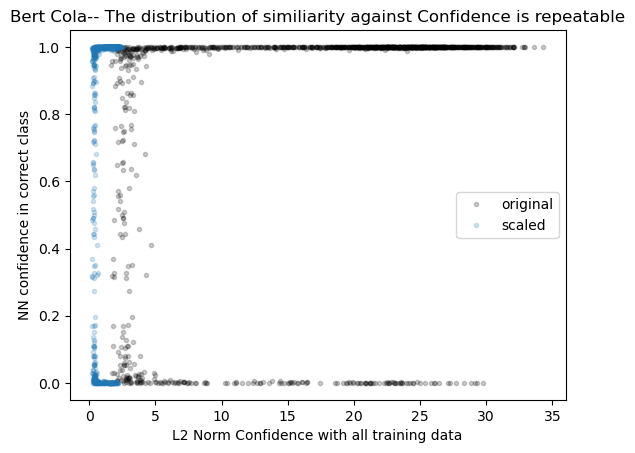

In [48]:
plt.title('Bert Cola-- The distribution of similiarity against Confidence is repeatable')
plt.plot(np.linalg.norm(K1_seedless,2,axis=1),confidences_seedless,'k.',alpha=0.2,label='original')
plt.plot(np.linalg.norm(K1_seedless_scaled,2,axis=1),confidences_seedless,'.',alpha=0.2,label='scaled')
plt.xlabel('L2 Norm Confidence with all training data')
plt.ylabel('NN confidence in correct class')
plt.legend()
plt.show()

(array([95., 27., 10., 11., 15.,  7., 21., 22., 10.,  8.]),
 array([ 1.67843997,  4.48780632,  7.29717302, 10.10653973, 12.91590595,
        15.72527218, 18.53463936, 21.34400558, 24.15337181, 26.96273804,
        29.77210426]),
 <BarContainer object of 10 artists>)

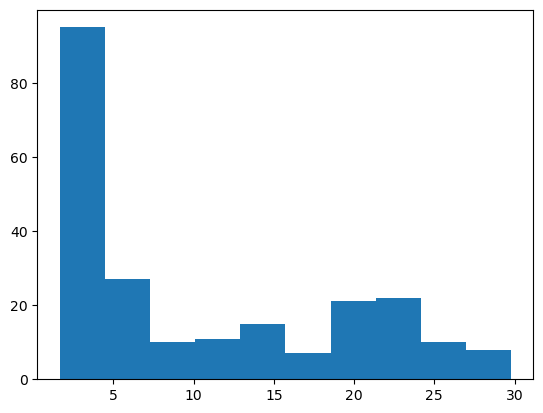

In [49]:
bins = 10 #np.linspace(0,35,20)
counts, __  = np.histogram(np.linalg.norm(K1_seedless,2,axis=1),bins=bins)
plt.hist(np.linalg.norm(K1_seedless,2,axis=1)[confidences_seedless<0.5],bins=bins,)

In [50]:
confidences_class_1_seedless = confidences_seedless.copy()
confidences_class_1_seedless[validation_labels==0] = 1 - confidences_class_1_seedless[validation_labels==0]

confidences_class_1_seed1 = confidences1.copy()
confidences_class_1_seed1[validation_labels==0] = 1 - confidences_class_1_seed1[validation_labels==0]

confidences_class_1_seed2 = confidences2.copy()
confidences_class_1_seed2[validation_labels==0] = 1 - confidences_class_1_seed2[validation_labels==0]

confidences_class_1_seed3 = confidences3.copy()
confidences_class_1_seed3[validation_labels==0] = 1 - confidences_class_1_seed3[validation_labels==0]

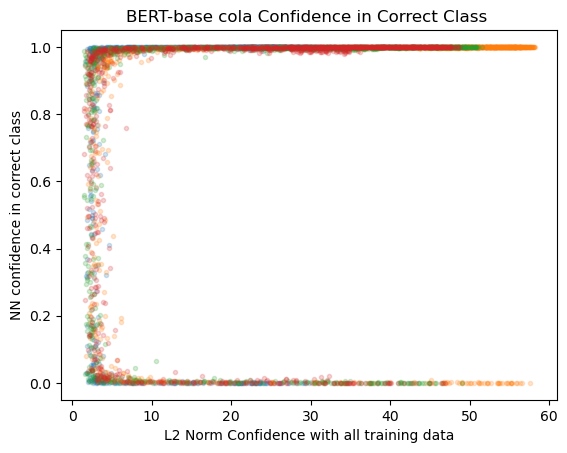

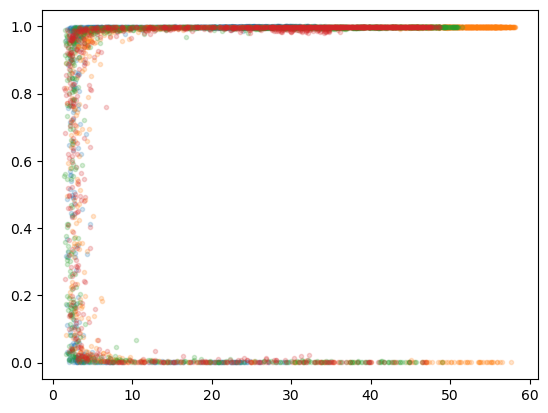

In [51]:
plt.title('BERT-base cola Confidence in Correct Class ',)
plt.plot(np.linalg.norm(K1_seedless,2,axis=1),confidences_seedless,'.',alpha=0.2,color='tab:blue')
plt.plot(np.linalg.norm(K1_seed1,2,axis=1),confidences1,'.',alpha=0.2,color='tab:orange')
plt.plot(np.linalg.norm(K1_seed2,2,axis=1),confidences2,'.',alpha=0.2,color='tab:green')
plt.plot(np.linalg.norm(K1_seed3,2,axis=1),confidences3,'.',alpha=0.2,color='tab:red')
plt.xlabel('L2 Norm Confidence with all training data')
plt.ylabel('NN confidence in correct class')
plt.show()

#plt.title('Bert Cola-- The distribution of similiarity against Confidence is repeatable')
plt.plot(np.linalg.norm(K1_seedless,2,axis=1),confidences_seedless,'.',alpha=0.2,color='tab:blue')
plt.plot(np.linalg.norm(K1_seed1,2,axis=1),confidences1,'.',alpha=0.2,color='tab:orange')
plt.plot(np.linalg.norm(K1_seed2,2,axis=1),confidences2,'.',alpha=0.2,color='tab:green')
plt.plot(np.linalg.norm(K1_seed3,2,axis=1),confidences3,'.',alpha=0.2,color='tab:red')
#plt.xlabel('L2 Norm Confidence with all training data')
#plt.ylabel('NN confidence in correct class')
plt.show()

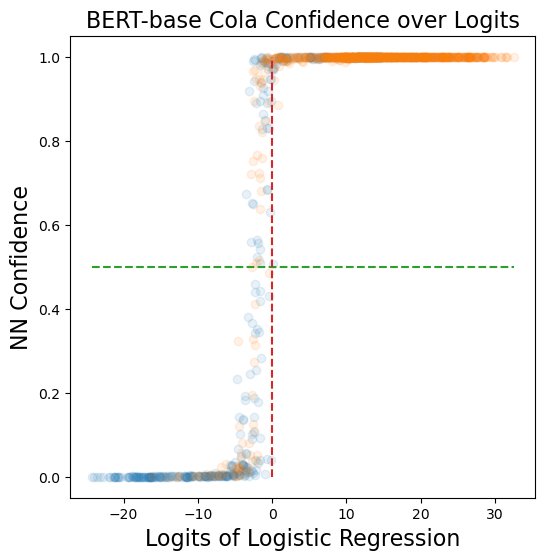

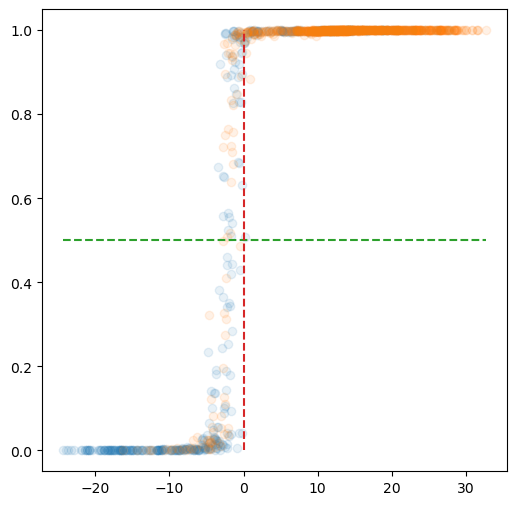

In [52]:
fig = plt.figure(figsize=(6,6))

plt.title('BERT-base Cola Confidence over Logits',fontsize=16)
mask0 = validation_labels==0
mask1 = validation_labels==1
plt.scatter(seedless_logits[mask0],confidences_class_1_seedless[mask0],alpha=0.1,color='tab:blue',)
plt.scatter(seedless_logits[mask1],confidences_class_1_seedless[mask1],alpha=0.1,color='tab:orange',)
# plt.plot(np.linalg.norm(K1_seed1,2,axis=1),confidences_class_1_seed1,'.',alpha=0.2,color='tab:orange',)
# plt.plot(np.linalg.norm(K1_seed2,2,axis=1),confidences_class_1_seed2,'.',alpha=0.2,color='tab:green',)
# plt.plot(np.linalg.norm(K1_seed3,2,axis=1),confidences_class_1_seed3,'.',alpha=0.2,color='tab:red',)
plt.xlabel('Logits of Logistic Regression',fontsize=16)
plt.ylabel('NN Confidence',fontsize=16)
plt.hlines(0.5,min(seedless_logits),max(seedless_logits),color='tab:green',linestyle='dashed',label="NN Decision Boundary")
plt.vlines(0,min(confidences_class_1_seedless),max(confidences_class_1_seedless),color='tab:red',linestyle='dashed',label='LogisticRegression Decision Boundary')
   
#plt.legend()
plt.show()

fig = plt.figure(figsize=(6,6))
#plt.title('Bert Cola-- The distribution of similiarity against Confidence is repeatable',)
mask0 = validation_labels==0
mask1 = validation_labels==1
plt.scatter(seedless_logits[mask0],confidences_class_1_seedless[mask0],alpha=0.1,color='tab:blue',)
plt.scatter(seedless_logits[mask1],confidences_class_1_seedless[mask1],alpha=0.1,color='tab:orange',)
# plt.plot(np.linalg.norm(K1_seed1,2,axis=1),confidences_class_1_seed1,'.',alpha=0.2,color='tab:orange')
# plt.plot(np.linalg.norm(K1_seed2,2,axis=1),confidences_class_1_seed2,'.',alpha=0.2,color='tab:green')
# plt.plot(np.linalg.norm(K1_seed3,2,axis=1),confidences_class_1_seed3,'.',alpha=0.2,color='tab:red')
#plt.xlabel('L2 Norm Confidence with all training data')
#plt.ylabel('NN confidence in correct class')
plt.hlines(0.5,min(seedless_logits),max(seedless_logits),color='tab:green',linestyle='dashed',label="NN Decision Boundary")
plt.vlines(0,min(confidences_class_1_seedless),max(confidences_class_1_seedless),color='tab:red',linestyle='dashed',label='LogisticRegression Decision Boundary')
plt.show()

### Lets get an estimate for the number of points in the vertical bar near 0 for all 4 models

In [53]:
print(np.sum(np.linalg.norm(K1_seedless,2,axis=1)<7))
print(np.sum(np.linalg.norm(K1_seed1,2,axis=1)<7))
print(np.sum(np.linalg.norm(K1_seed2,2,axis=1)<7))
print(np.sum(np.linalg.norm(K1_seed3,2,axis=1)<7))

306
223
232
258


### Let's get an estimate for the horizontal bars (confidence = 0,1)

In [54]:
print(np.sum(np.logical_or(confidences_seedless>0.99,confidences_seedless<0.01)))
print(np.sum(np.logical_or(confidences1>0.99,confidences1<0.01)))
print(np.sum(np.logical_or(confidences2>0.99,confidences2<0.01)))
print(np.sum(np.logical_or(confidences3>0.99,confidences3<0.01)))

1178
1136
1151
1055


### Compute confusion tables for each model (we can use only the horizontal bars or all data)

In [55]:
true_classifications_indices_seedless = np.where(confidences_seedless>0.99)[0]
true_classifications_indices_seed1 = np.where(confidences1>0.99)[0]
true_classifications_indices_seed2 = np.where(confidences2>0.99)[0]
true_classifications_indices_seed3 = np.where(confidences3>0.99)[0]

false_classifications_indices_seedless = np.where(confidences_seedless<0.01)[0]
false_classifications_indices_seed1 = np.where(confidences1<0.01)[0]
false_classifications_indices_seed2 = np.where(confidences2<0.01)[0]
false_classifications_indices_seed3 = np.where(confidences3<0.01)[0]

low_confidence_indices_seedless = np.where(np.linalg.norm(K1_seedless,2,axis=1)<7)[0]
low_confidence_indices_seed1 = np.where(np.linalg.norm(K1_seed1,2,axis=1)<7)[0]
low_confidence_indices_seed2 = np.where(np.linalg.norm(K1_seed2,2,axis=1)<7)[0]
low_confidence_indices_seed3 = np.where(np.linalg.norm(K1_seed3,2,axis=1)<7)[0]

total_indices_seedless = np.unique(np.concatenate([true_classifications_indices_seedless,false_classifications_indices_seedless]))
total_indices_seed1 = np.unique(np.concatenate([true_classifications_indices_seed1,false_classifications_indices_seed1]))
total_indices_seed2 = np.unique(np.concatenate([true_classifications_indices_seed2,false_classifications_indices_seed2]))
total_indices_seed3 = np.unique(np.concatenate([true_classifications_indices_seed3,false_classifications_indices_seed3]))

Limited Confusion Matrices:: I'm just looking at the Bars


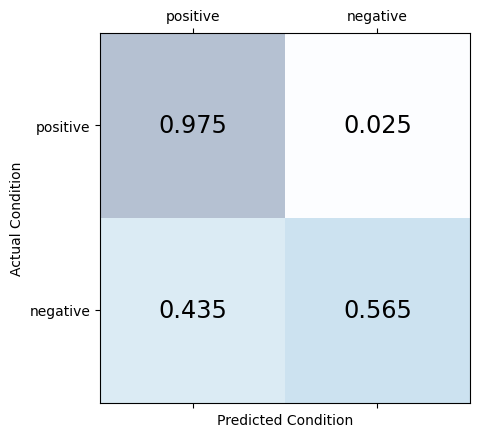

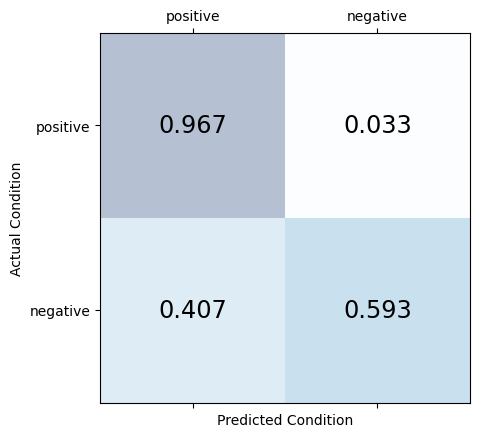

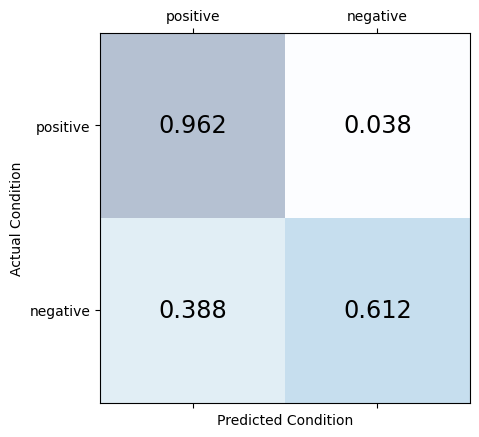

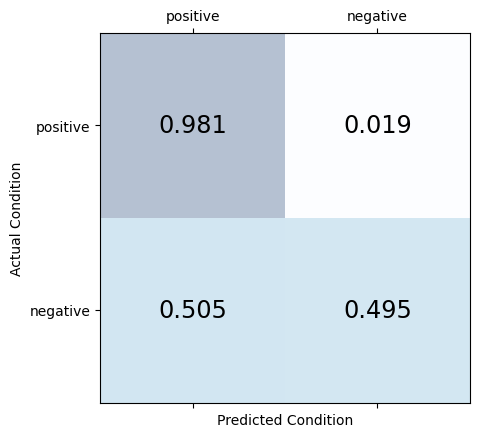

In [56]:
def confusion_matrix(A,B,C):
    
    conf_matrix = np.array([
            [(validation_labels[A]==1).sum()/((validation_labels[C]==1).sum()),
            (validation_labels[B]==1).sum()/((validation_labels[C]==1).sum()),
            ],
            [ 
            (validation_labels[B]==0).sum()/((validation_labels[C]==0).sum()),
            (validation_labels[A]==0).sum()/((validation_labels[C]==0).sum())   
            ]
        ])

    ax = plt.subplot(111)
    ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(x=j, y=i,s='{:.3f}'.format(conf_matrix[i, j]), va='center', ha='center', size='xx-large')
    plt.xticks([0,1],['positive','negative'])
    plt.yticks([0,1],['positive','negative'])
    plt.ylabel('Actual Condition')
    plt.xlabel('Predicted Condition')
    plt.show()
    
print("Limited Confusion Matrices:: I'm just looking at the Bars")
confusion_matrix(true_classifications_indices_seedless,false_classifications_indices_seedless,total_indices_seedless)
confusion_matrix(true_classifications_indices_seed1,false_classifications_indices_seed1,total_indices_seed1)
confusion_matrix(true_classifications_indices_seed2,false_classifications_indices_seed2,total_indices_seed2)
confusion_matrix(true_classifications_indices_seed3,false_classifications_indices_seed3,total_indices_seed3)

### Try to understand the difference between the two horizontal bars...and we can do this by looking at the distribution of the vectors J*x for each test point x. What do I mean here? Well, what if in the true positive/negative classifications, we get strong alignment to only a few training points from a single class but in the false positive/negative classifications, we get weak alignment but for all training points in one class. Then the aggregate of the weak alignments would still give us a relatively large L2 norm in the class but we can attribute that to some kind of random similarity to features of a class, etc. This is just a guess but let's try to look to see what might be happening here.

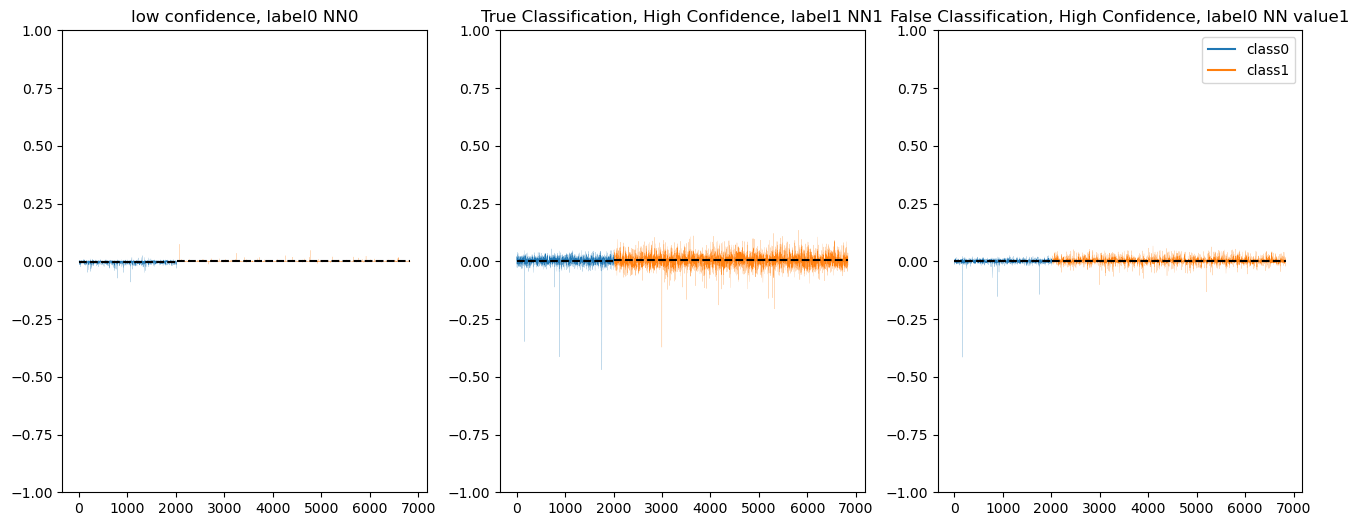

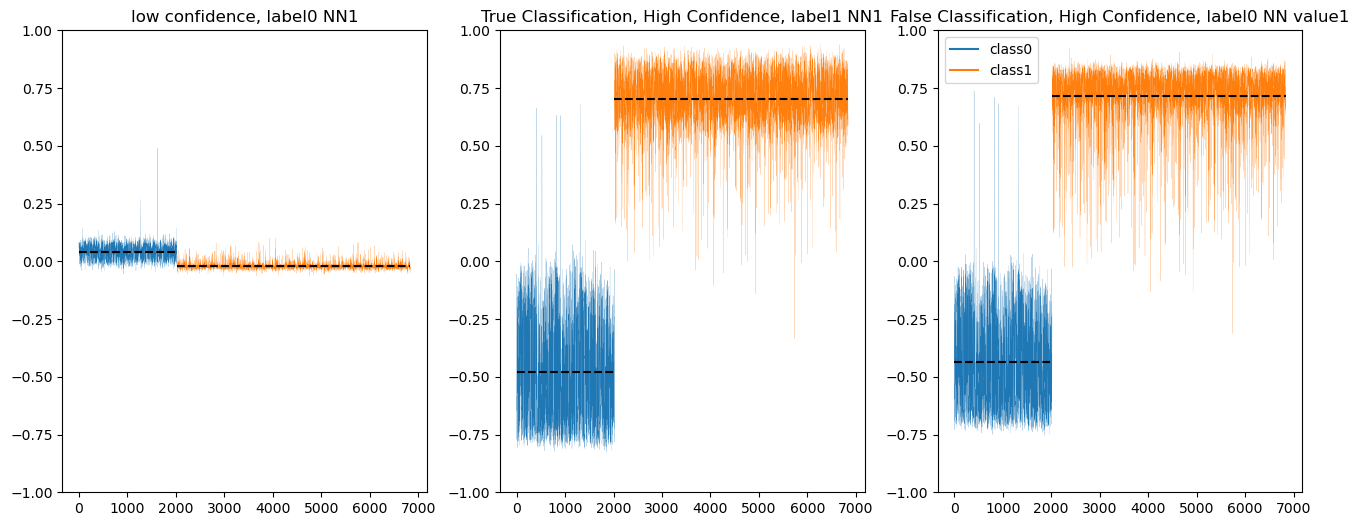

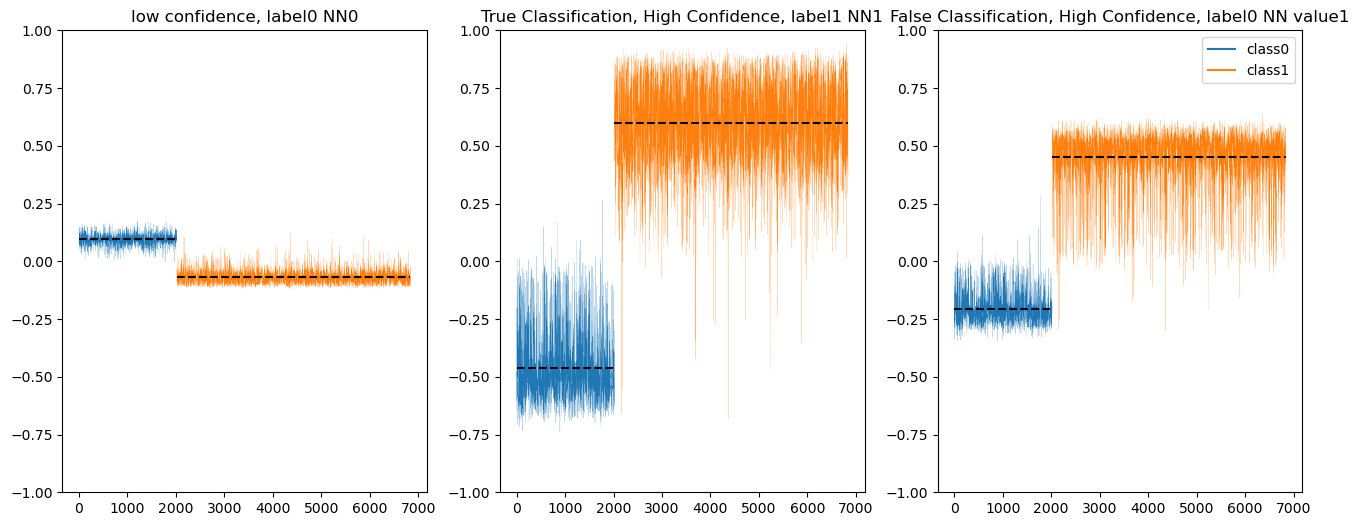

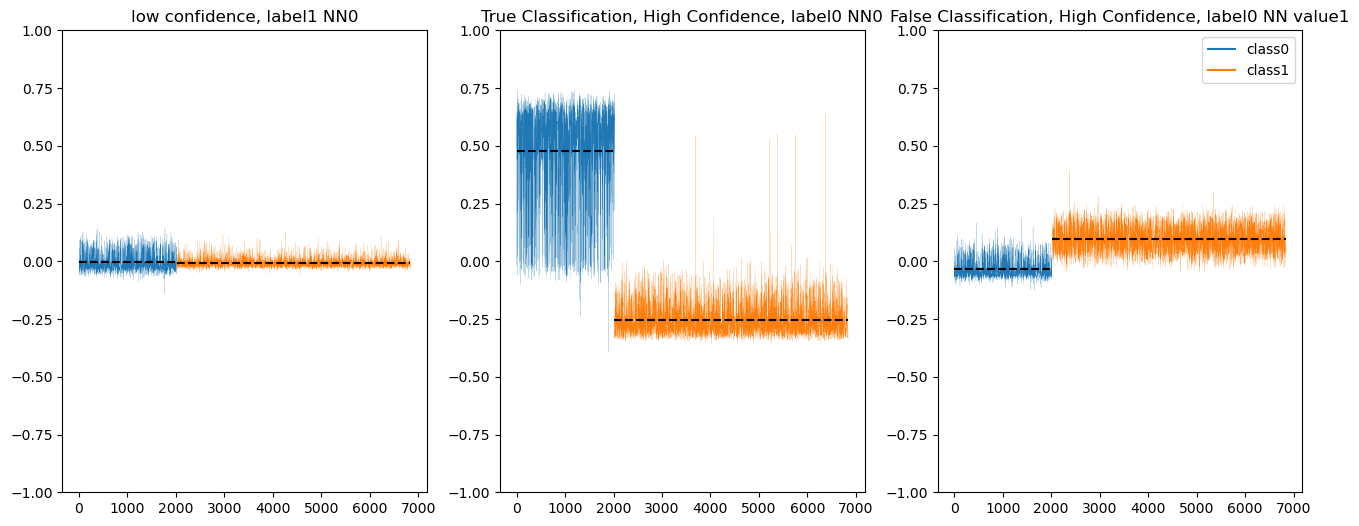

In [57]:
def visualize_Jx(low_confidence_indices_seedless,
                 true_classifications_indices_seedless,
                 false_classifications_indices_seedless,
                 K1_seedless):

    fig = plt.figure(figsize=(16,6))

    plt.subplot(1,3,1)
    plt.ylim(-1,1)
    i = np.random.choice(low_confidence_indices_seedless )
    plt.plot(np.arange((train_labels==0).sum()),K1_seedless[i][train_labels==0],linewidth=0.1,alpha=1.0)
    plt.plot(np.arange((train_labels==0).sum(),(train_labels==0).sum()+(train_labels==1).sum()),K1_seedless[i][train_labels==1],linewidth=0.1,alpha=1.0)
    plt.hlines(np.mean(K1_seedless[i][train_labels==0]),0,(train_labels==0).sum(),color='k',linestyle='dashed')
    plt.hlines(np.mean(K1_seedless[i][train_labels==1]),(train_labels==0).sum(),(train_labels==0).sum()+(train_labels==1).sum(),color='k',linestyle='dashed')
    plt.title('low confidence, label{} NN{}'.format(validation_labels[i],NNseedless_pred[i]))


    plt.subplot(1,3,2)
    plt.ylim(-1,1)
    i = np.random.choice(true_classifications_indices_seedless)
    while i in low_confidence_indices_seedless:
        i = np.random.choice(true_classifications_indices_seedless)
    plt.plot(np.arange((train_labels==0).sum()),K1_seedless[i][train_labels==0],linewidth=0.1,alpha=1.0)
    plt.plot(np.arange((train_labels==0).sum(),(train_labels==0).sum()+(train_labels==1).sum()),K1_seedless[i][train_labels==1],linewidth=0.1,alpha=1.0)
    plt.hlines(np.mean(K1_seedless[i][train_labels==0]),0,(train_labels==0).sum(),color='k',linestyle='dashed')
    plt.hlines(np.mean(K1_seedless[i][train_labels==1]),(train_labels==0).sum(),(train_labels==0).sum()+(train_labels==1).sum(),color='k',linestyle='dashed')
    plt.title('True Classification, High Confidence, label{} NN{}'.format(validation_labels[i],NNseedless_pred[i]))


    plt.subplot(1,3,3)
    plt.ylim(-1,1)
    i = np.random.choice(false_classifications_indices_seedless)
    while i in low_confidence_indices_seedless:
        i = np.random.choice(false_classifications_indices_seedless)
    plt.plot(np.arange((train_labels==0).sum()),K1_seedless[i][train_labels==0],linewidth=0.1,alpha=1.0,)
    plt.plot(np.arange((train_labels==0).sum(),(train_labels==0).sum()+(train_labels==1).sum()),K1_seedless[i][train_labels==1],linewidth=0.1,alpha=1.0)
    plt.hlines(np.mean(K1_seedless[i][train_labels==0]),0,(train_labels==0).sum(),color='k',linestyle='dashed')
    plt.hlines(np.mean(K1_seedless[i][train_labels==1]),(train_labels==0).sum(),(train_labels==0).sum()+(train_labels==1).sum(),color='k',linestyle='dashed')
    plt.title('False Classification, High Confidence, label{} NN value{}'.format(validation_labels[i],NNseedless_pred[i]))
    plt.plot([0,1],[-100,-101],color='tab:blue',label='class0')
    plt.plot([0,1],[-100,-101],color='tab:orange',label='class1')
    plt.legend()
    
    plt.show()
    
np.random.seed(0)
visualize_Jx(low_confidence_indices_seedless,
             true_classifications_indices_seedless,
             false_classifications_indices_seedless,
             K1_seedless_scaled)

visualize_Jx(low_confidence_indices_seed1,
             true_classifications_indices_seed1,
             false_classifications_indices_seed1,
             K1_seed1)

visualize_Jx(low_confidence_indices_seed2,
             true_classifications_indices_seed2,
             false_classifications_indices_seed2,
             K1_seed2)

visualize_Jx(low_confidence_indices_seed3,
             true_classifications_indices_seed3,
             false_classifications_indices_seed3,
             K1_seed3)

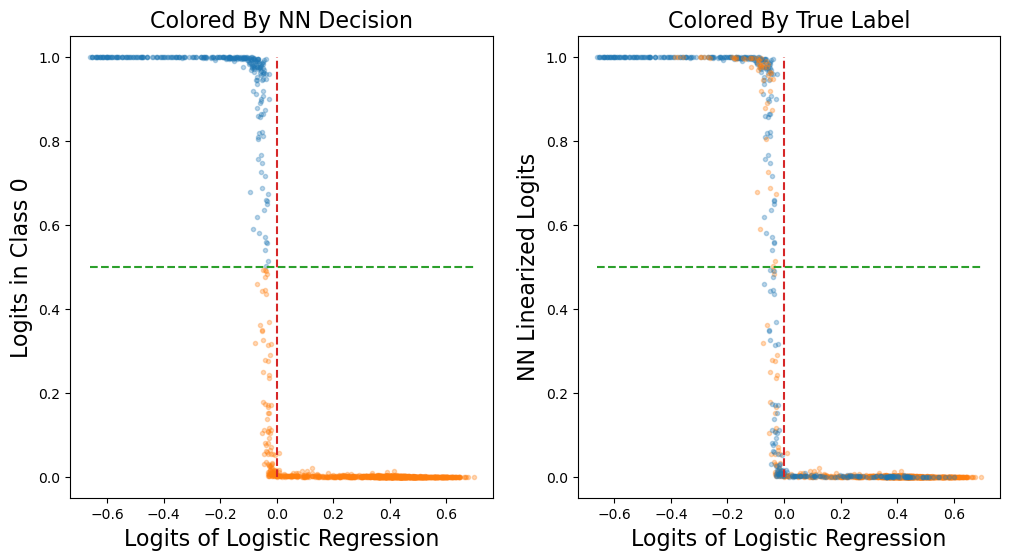

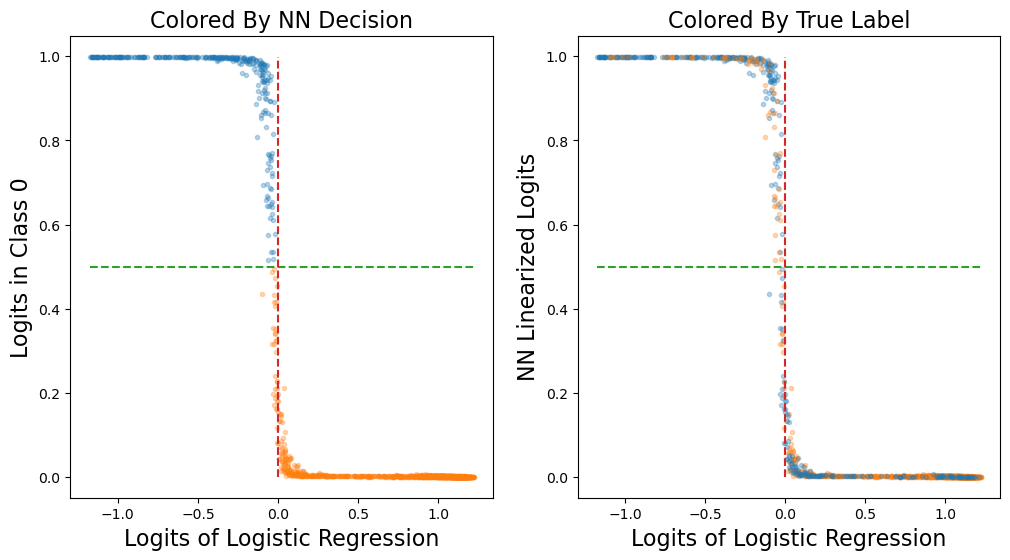

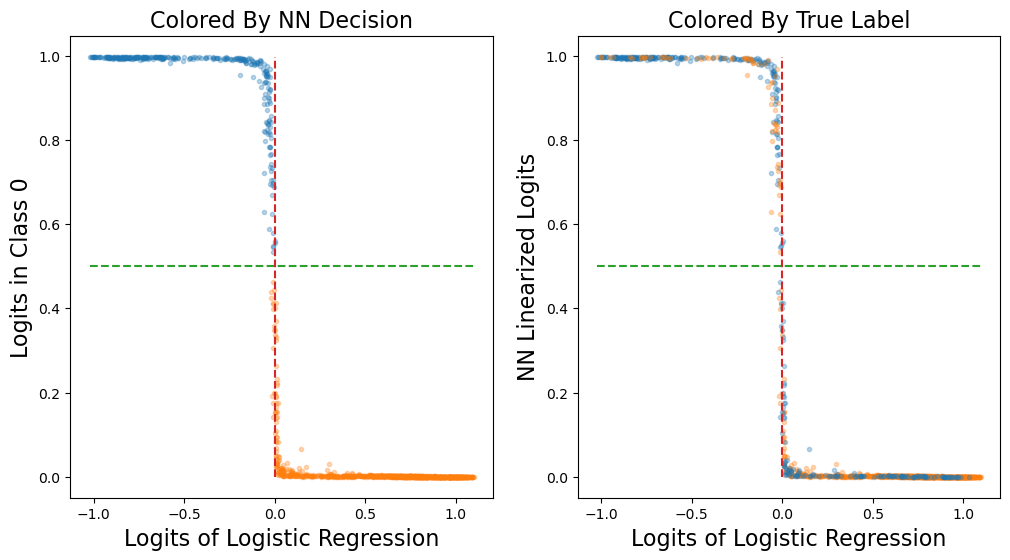

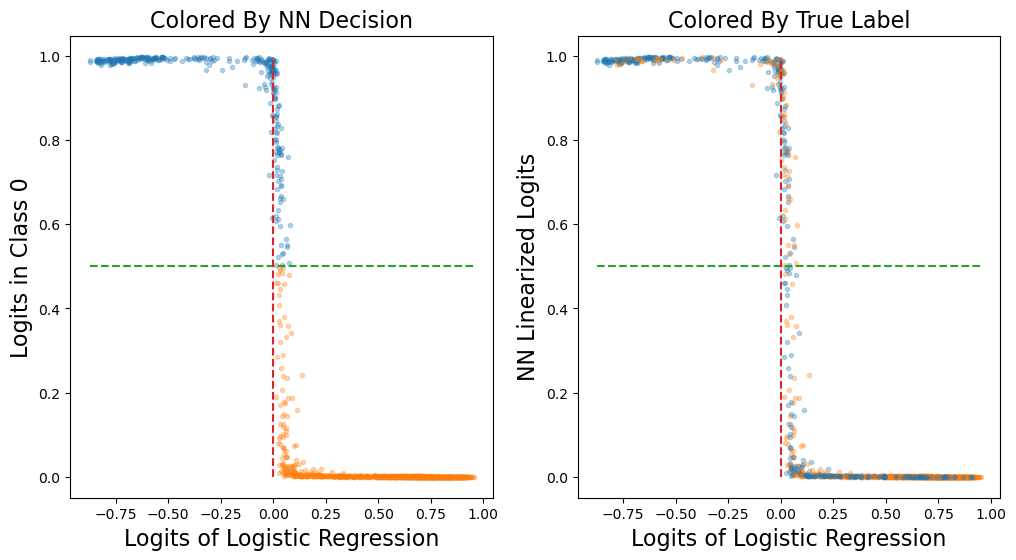

In [58]:
def possible_correlation(K1,NN_ys,intercept,y,reduction):
    differences = []
    confidences = []
    NN_guesses = []
    Correct_Labels = []
    for i in range(len(K1)):
        
        if reduction=='max':
            class0_mean = np.max(K1[i][train_labels==0])
            class1_mean = np.max(K1[i][train_labels==1])
        elif reduction == 'mean':
            class0_mean = np.mean(K1[i][train_labels==0])
            class1_mean = np.mean(K1[i][train_labels==1])
        elif reduction == 'sum':
            class0_mean = np.sum(K1[i][train_labels==0])
            class1_mean = np.sum(K1[i][train_labels==1])
            
        confidence = np.max(NN_ys[i]) #strictly greater than 0.5
        NN_guess = np.argmax(NN_ys[i])
        
        differences.append(class1_mean - class0_mean)
        if NN_guess==0:
            confidences.append(confidence)
        else:
            confidences.append(1-confidence)
        NN_guesses.append(NN_guess)
        Correct_Labels.append(validation_labels[i])
        
    differences = np.array(differences)
    confidences = (np.array(confidences))
    NN_guesses = np.array(NN_guesses)
    Correct_Labels = np.array(Correct_Labels)
    
    fig = plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    #plt.hlines(0.5,-0.6,0.6,color='k',linestyle='dashed',label='NN decision Boundary')
    plt.plot(differences[NN_guesses==0],(confidences[NN_guesses==0]),'.',alpha=0.3)
    plt.plot(differences[NN_guesses==1],(confidences[NN_guesses==1]),'.',alpha=0.3)
    #plt.ylim(0.45,1.05)
    plt.title('Colored By NN Decision',fontsize=16)
    plt.ylabel('Logits in Class 0',fontsize=16)
    #plt.plot(differences,logit(y),'k.')
    plt.xlabel('Logits of Logistic Regression',fontsize=16)
    plt.hlines(0.5,min(differences),max(differences),color='tab:green',linestyle='dashed',label="NN Decision Boundary")
    plt.vlines(0,min(confidences),max(confidences),color='tab:red',linestyle='dashed',label='LogisticRegression Decision Boundary')
    
    plt.subplot(1,2,2)
    #plt.hlines(0.5,-0.6,0.6,color='k',linestyle='dashed',label='NN decision Boundary')
    
    mask_ = confidences[Correct_Labels==0] > 0.5
    plt.plot(differences[Correct_Labels==0][mask_],confidences[Correct_Labels==0][mask_],'.',alpha=0.3,color='tab:blue')
    
    mask_ = confidences[Correct_Labels==1] < 0.5
    plt.plot(differences[Correct_Labels==1][mask_],confidences[Correct_Labels==1][mask_],'.',alpha=0.3,color='tab:orange')
    
    mask_ = confidences[Correct_Labels==0] < 0.5
    plt.plot(differences[Correct_Labels==0][mask_],confidences[Correct_Labels==0][mask_],'.',alpha=0.3,color='tab:blue')
    
    mask_ = confidences[Correct_Labels==1] > 0.5
    plt.plot(differences[Correct_Labels==1][mask_],confidences[Correct_Labels==1][mask_],'.',alpha=0.3,color='tab:orange')
    plt.title('Colored By True Label',fontsize=16)
    #plt.ylim(0.45,1.05)
    plt.ylabel('NN Linearized Logits',fontsize=16)
    plt.xlabel('Logits of Logistic Regression',fontsize=16)
    plt.hlines(0.5,min(differences),max(differences),color='tab:green',linestyle='dashed',label="NN Decision Boundary")
    plt.vlines(0,min(confidences),max(confidences),color='tab:red',linestyle='dashed',label='LogisticRegression Decision Boundary')
    
    plt.show()
    
REDUCTION = 'mean'
possible_correlation(K1_seedless,NNseedless_ys,0.0,y_seedless,REDUCTION)
possible_correlation(K1_seed1,NN1_ys,0.0,y_seed1,REDUCTION)
possible_correlation(K1_seed2,NN2_ys,0.0,y_seed2,REDUCTION)
possible_correlation(K1_seed3,NN3_ys,0.0,y_seed3,REDUCTION)    
    
# possible_correlation(K1_seedless,NNseedless_ys,K1_seedless_intercept)
# possible_correlation(K1_seed1,NN1_ys,K1_seed1_intercept)
# possible_correlation(K1_seed2,NN2_ys,K1_seed2_intercept)
# possible_correlation(K1_seed3,NN3_ys,K1_seed3_intercept)

In [59]:
from scipy.optimize import minimize
from scipy.special import erf
from scipy.stats import norm
from math import log
from sklearn.metrics import r2_score
from scipy.stats import kendalltau

def model_inv(x,A,K,nu):
    return  K * np.log((x**nu) / (1-x**nu)) + A

def model_inv_tan(x,A,K,nu):
    return -K * np.tan(np.pi/2 - np.pi*x**nu) + A

def loss(Theta,GLM_logits,NN_p):
    A = Theta[0]
    K = Theta[1]
    nu = Theta[2]
    
    NN_linearized_logits = model_inv_tan(NN_p,A,K,nu)

    loss = np.mean((NN_linearized_logits-GLM_logits)**2)
    
    return loss

def softmax_numpy(x):
    return np.exp(x) / np.sum(np.exp(x))

def numpy_softmax(x):
    return np.exp(x) / np.sum(np.exp(x))

def linloss(Theta,X,NNY,TANGENT=False):
    M = Theta[0]
    B = Theta[1]
    
    YGLM = X * M + B
        
    loss = np.mean((YGLM-NNY)**2)
    
    return loss

def make_my_forward_fit(K1_scaled,
                        NN_y,
                        intercept,
                        PLOT_LOGITS=False,
                        method=None,
                        constraints=[(None,None),(1e-4,None),(0.90,10)],
                        x0=np.array([0.0,0.02,1.2,])):
    '''
    Here I want to linearize the NN output Y. I'll do that by using a correlation loss to X.
    '''
    X = np.sum(K1_scaled,axis=1) + intercept
    Y = NN_y[:,1]
    
    #A, K, nu = Bias, Slope, Exponents
    #constraints = 
    #x0 =
    res = minimize(loss,x0=x0,args=(X,Y),bounds=constraints,method=method)
    print(res.x)
    A =res.x[0]
    K =res.x[1]
    nu = res.x[2]
    
    Y_linearized_end = model_inv_tan(Y,A,K,nu)
    
    mask_1 = validation_labels==0
    mask_0 = validation_labels==1
    plt.hlines(model_inv_tan(0.5,A,K,nu),min(X),max(X),color='tab:green',linestyle='dashed',label="NN Decision Boundary")
    print('New Model Decision Boundary',model_inv_tan(0.5,A,K,nu))
    plt.vlines(0,min(Y_linearized_end),max(Y_linearized_end),color='tab:red',linestyle='dashed',label='LogisticRegression Decision Boundary')
    plt.scatter(X[mask_0],Y_linearized_end[mask_0],alpha=0.15,label='Corr Class=0')
    plt.scatter(X[mask_1],Y_linearized_end[mask_1],alpha=0.15,label='Corr Class=1')
    plt.plot([min(Y_linearized_end),max(Y_linearized_end)],[min(Y_linearized_end),max(Y_linearized_end)],'k--',label='logistic regression fit')
    #plt.plot(X,X,'.',alpha=0.3,color='k',label='logistic regression fit')
    
    #R_squared = (np.corrcoef(X,Y_linearized_end)[0,1])**2
    R_squared = r2_score(X,Y_linearized_end)
    
    tau = kendalltau(X,Y).correlation
    
    plt.text(0.95*min(X),0.75*max(Y_linearized_end),'R^2={:.3f}'.format(R_squared),fontsize=15)
    return R_squared, tau
    
# res_seedless = make_my_inverse_fit(K1_seedless,K1_seedless_scaled,NNseedless_ys,K1_seedless_intercept)
# res_seed1 = make_my_inverse_fit(K1_seed1,K1_seed1_scaled,NN1_ys,K1_seed1_intercept)
# res_seed2 = make_my_inverse_fit(K1_seed2,K1_seed2_scaled,NN2_ys,K1_seed2_intercept)
# res_seed3 = make_my_inverse_fit(K1_seed3,K1_seed3_scaled,NN3_ys,K1_seed3_intercept)

def compute_tau(logits_GLM,logits_NN,intercept):
    X = sigmoid(np.sum(logits_GLM,axis=1) + intercept)
    Y = logits_NN[:,1] #these are already softmax-scaled
    
    all_xs_tau = []
    all_ys_tau = []
    for i,label in enumerate(range(len(validation_labels))):
        all_xs_tau.append(X[i,])
        all_ys_tau.append(Y[i,])
    Tau = kendalltau(np.array(all_xs_tau),np.array(all_ys_tau)).correlation #TAU IS computed before the linear relationship is scaled.
    
    return Tau

In [99]:
plt.rcParams['text.usetex'] = False
def new_func(X,Theta):
    
    a=Theta[0]
    b=Theta[1]
    c=Theta[2]
    s=Theta[3]
    
    #Y = np.exp((X-a)/b)
    #Y = s*(Y/(1+Y)) + c
    
    Y = -1*s*np.arctan(-1*(X-a)/(2*b))/np.pi + 1/2 + c
    return Y


def guesses(X,Y):
    c = np.quantile(Y,0.01)/4
    s = np.quantile(Y,0.90)-4*c
    DB = (0.5*s + c)
    a = 1*X[np.argmin(abs(Y-0))]
    
    m_index = np.argsort(abs(Y-DB))[0:2]
    m = (Y[m_index[1]] - Y[m_index[0]]) / (X[m_index[1]] - X[m_index[0]])
    if m < 0:
        m=m*-1
    m=1.2

    b = s/(4*m)
    Theta = np.array([a,b,c,s])
    #print('initial Guess: ',Theta)
    return Theta

def new_loss(Theta,X,Y):
    delta=1.0
    Yhat = new_func(X,Theta)
    E=abs(Yhat-Y)
    maskh = E>delta
    HuberLoss=0
    HuberLoss+= np.sum((delta*E[maskh] - 0.5*delta))
    HuberLoss+= np.sum((delta*(Yhat-Y)[~maskh]**2))
    return HuberLoss

def forward_fit_final(logits_GLM,logits_NN,intercept,tau,method='Nelder-Mead',PLOT=True):
    X = np.sum(logits_GLM,axis=1) + intercept #this is an activation
    Y = logits_NN[:,1] #these are already softmax-scaled
    
    Y=logit(Y) #now they are activations.
        
    x0 =  guesses(X[0::2],Y[0::2])
    res = minimize(new_loss,x0=x0,args=(X[0::2],Y[0::2]),method=method)
    Theta = res.x
    DS = 0.5*Theta[3] +Theta[2]
    Yhat = new_func(X,Theta)

    R_squared = r2_score(Yhat[1::2],Y[1::2])
    
    if PLOT:
        Yhat = Yhat[1::2]
        Y = Y[1::2]
        validation_labels_ = validation_labels[1::2]
        
        mask0 = validation_labels_==0
        mask1 = validation_labels_==1
        #After Mapping
        plt.plot(Yhat[mask0],Y[mask0],'.',alpha=0.3,)
        plt.plot(Yhat[mask1],Y[mask1],'s',alpha=0.3,)
        plt.plot([np.min(Y),np.max(Y)],[np.min(Y),np.max(Y)],'k--',label='Parity')
        plt.text(-0.95*np.max(Yhat),1.3*np.max(Y),'R$^2$={:.2f}'.format(R_squared),fontsize=14)
        plt.text(-0.95*np.max(Yhat),1.1*np.max(Y),r'$\tau$={:.2f}'.format(tau),fontsize=14)
        #plt.ylabel(f'NN Activations',fontsize=14)
        #plt.xlabel(f'kGLM Scaled Activations',fontsize=14)
        #plt.title(f'NN Predicted Class',fontsize=14)
        plt.ylim(np.min(Y)-5,np.max(Y)+5)
        plt.xlim(np.min(Yhat)-5,np.max(Yhat)+5)
        plt.plot(-1000,-1000,'.',color='tab:blue',label='True Class z = 0')
        plt.plot(-1000,-1000,'s',color='tab:orange',label='True Class z = 1')
        #plt.show()
    
    

    return R_squared

In [90]:
tau0 = compute_tau(K1_seedless_scaled,NNseedless_ys,K1_seedless_intercept)
tau1 = compute_tau(K1_seed1_scaled,NN1_ys,K1_seed1_intercept)
tau2 = compute_tau(K1_seed2_scaled,NN2_ys,K1_seed2_intercept)
tau3 = compute_tau(K1_seed3_scaled,NN3_ys,K1_seed3_intercept)

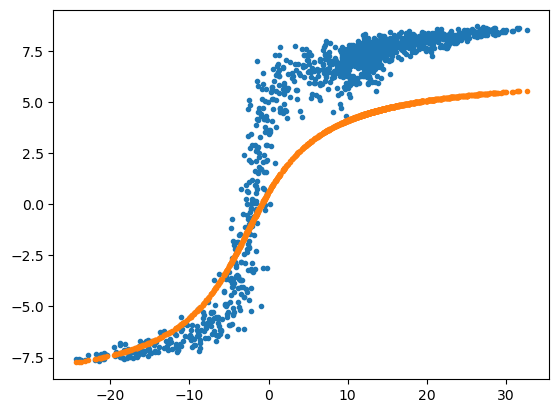

In [91]:
X = np.sum(K1_seedless_scaled,axis=1)+K1_seedless_intercept #X is a final activation.
Y = logit(NNseedless_ys[:,1])
plt.plot(X,Y,'.')
Theta = guesses(X,Y)
Yhat=new_func(X,Theta)
plt.plot(X,Yhat,'.')

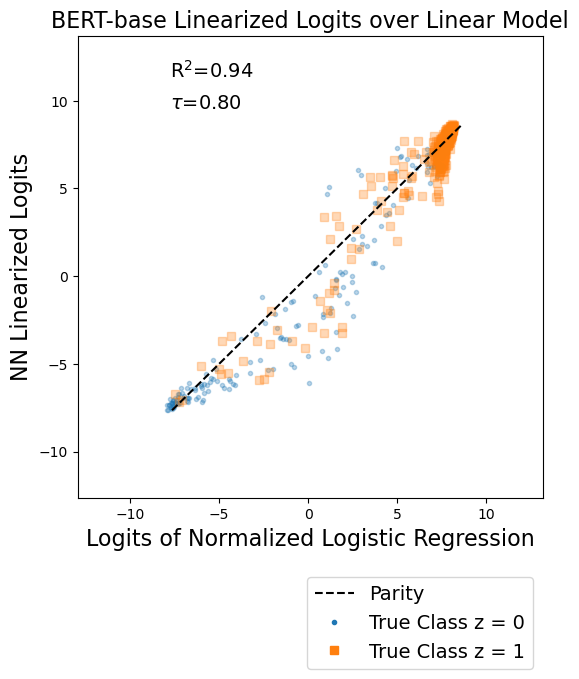

In [100]:
# fig = plt.figure(figsize=(12,12))
# plt.subplot(2,2,1)
fig = plt.figure(figsize=(6,6))
plt.title('BERT-base Linearized Logits over Linear Model',fontsize=16)
plt.xlabel('Logits of Normalized Logistic Regression',fontsize=16)
plt.ylabel('NN Linearized Logits',fontsize=16)
Rsquared_seedless = forward_fit_final(K1_seedless_scaled,NNseedless_ys,K1_seedless_intercept,tau=tau0,method='Nelder-Mead')
plt.legend(bbox_to_anchor=(1.0,-.15),fontsize=14)
plt.savefig('/rcfs/projects/task0_pmml/images/BertSeedlessLinearLogits.pdf',bbox_inches='tight')
plt.show()

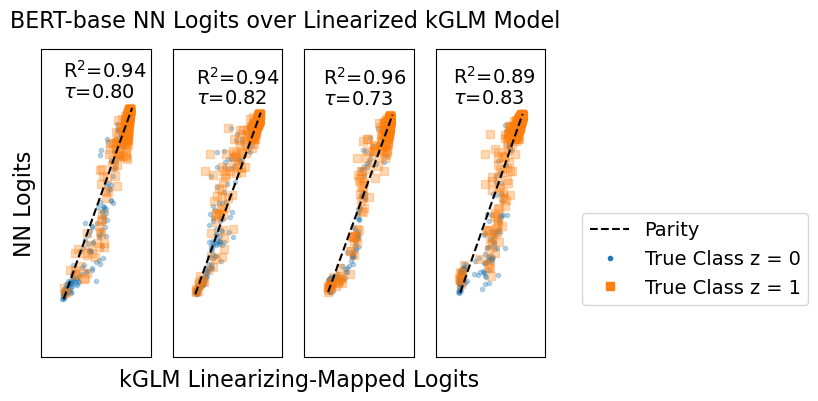

In [102]:
fig = plt.figure(figsize=(6.5,4))

plt.suptitle('BERT-base NN Logits over Linearized kGLM Model',fontsize=16)

plt.subplot(141)
#plt.title('BERT-base Linearized Logits over Linear Model',fontsize=16)
#plt.xlabel('Logits of Normalized Logistic Regression',fontsize=16)

plt.ylabel('NN Logits',fontsize=16)
Rsq0 = forward_fit_final(K1_seedless_scaled,NNseedless_ys,K1_seedless_intercept,tau=tau0,method='Nelder-Mead')
plt.xticks([])
plt.yticks([])

plt.subplot(142)
#plt.title('BERT-base Linearized Logits over Linear Model',fontsize=16)
#plt.xlabel('Logits of Normalized Logistic Regression',fontsize=16)
#plt.ylabel('NN Linearized Logits',fontsize=16)

Rsq1 = forward_fit_final(K1_seed1_scaled,NN1_ys,K1_seed1_intercept,tau=tau1,method='Nelder-Mead')
plt.xticks([])
plt.yticks([])

plt.subplot(143)
#plt.title('BERT-base Linearized Logits over Linear Model',fontsize=16)
#plt.xlabel('Logits of Normalized Logistic Regression',fontsize=16)
#plt.ylabel('NN Linearized Logits',fontsize=16)

Rsq2 = forward_fit_final(K1_seed2_scaled,NN2_ys,K1_seed2_intercept,tau=tau2,method='Nelder-Mead')
plt.xticks([])
plt.yticks([])
plt.text(-50,-13,'kGLM Linearizing-Mapped Logits',fontsize=16)

plt.subplot(144)
#plt.title('BERT-base Linearized Logits over Linear Model',fontsize=16)
#plt.xlabel('Logits of Normalized Logistic Regression',fontsize=16)
#plt.ylabel('NN Linearized Logits',fontsize=16)
Rsq3 = forward_fit_final(K1_seed3_scaled,NN3_ys,K1_seed3_intercept,tau=tau3,method='Nelder-Mead')
plt.xticks([])
plt.yticks([])
plt.legend(bbox_to_anchor=(1.25,0.5),fontsize=14)
plt.savefig('/rcfs/projects/task0_pmml/images/4BertLinearLogits_small.pdf',bbox_inches='tight')
plt.show()

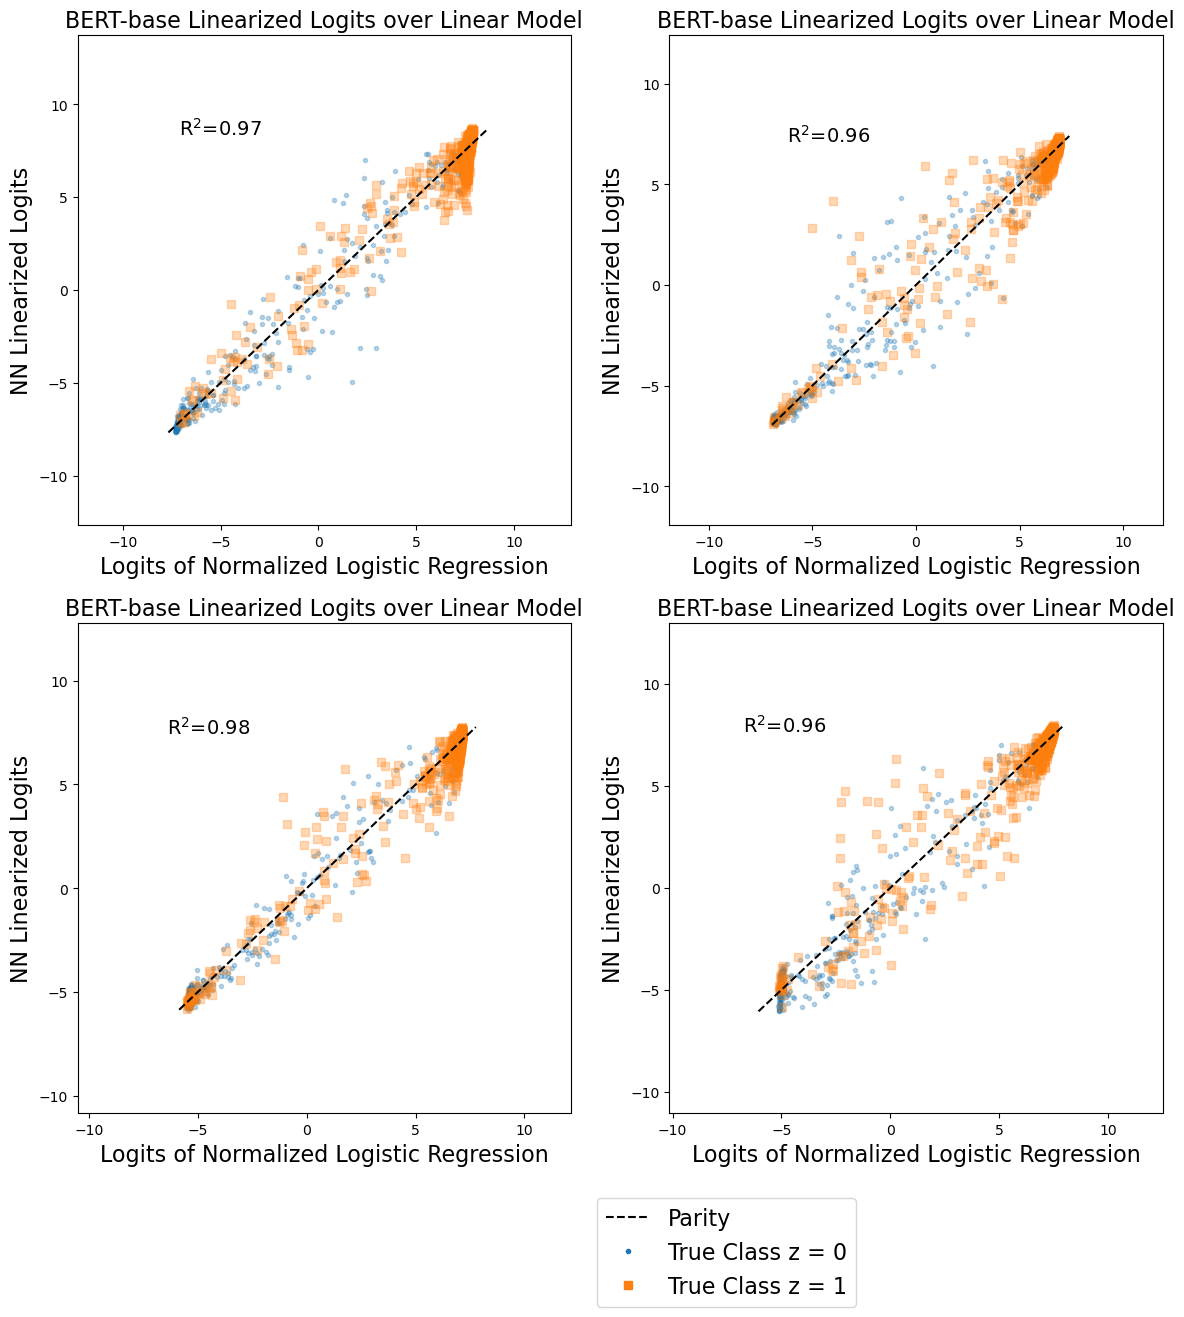

In [63]:
fig = plt.figure(figsize=(14,14))

plt.subplot(221)
plt.title('BERT-base Linearized Logits over Linear Model',fontsize=16)
plt.xlabel('Logits of Normalized Logistic Regression',fontsize=16)
plt.ylabel('NN Linearized Logits',fontsize=16)
Rsq0 = forward_fit_final(K1_seedless_scaled,NNseedless_ys,K1_seedless_intercept,method='Nelder-Mead')

plt.subplot(222)
plt.title('BERT-base Linearized Logits over Linear Model',fontsize=16)
plt.xlabel('Logits of Normalized Logistic Regression',fontsize=16)
plt.ylabel('NN Linearized Logits',fontsize=16)
Rsq1 = forward_fit_final(K1_seed1_scaled,NN1_ys,K1_seed1_intercept,method='Nelder-Mead')

plt.subplot(223)
plt.title('BERT-base Linearized Logits over Linear Model',fontsize=16)
plt.xlabel('Logits of Normalized Logistic Regression',fontsize=16)
plt.ylabel('NN Linearized Logits',fontsize=16)
Rsq2 = forward_fit_final(K1_seed2_scaled,NN2_ys,K1_seed2_intercept,method='Nelder-Mead')

plt.subplot(224)
plt.title('BERT-base Linearized Logits over Linear Model',fontsize=16)
plt.xlabel('Logits of Normalized Logistic Regression',fontsize=16)
plt.ylabel('NN Linearized Logits',fontsize=16)
Rsq3 = forward_fit_final(K1_seed3_scaled,NN3_ys,K1_seed3_intercept,method='Nelder-Mead')
plt.legend(bbox_to_anchor=(0.4,-.15),fontsize=16)
plt.savefig('/rcfs/projects/task0_pmml/images/4BertLinearLogitssquare.pdf',bbox_inches='tight')
plt.show()

In [64]:
# fig = plt.figure(figsize=(14,14))

# plt.subplot(221)
# plt.title('BERT-base Linearized Logits over Linear Model',fontsize=16)
# plt.xlabel('Logits of Normalized Logistic Regression',fontsize=16)
# plt.ylabel('NN Linearized Logits',fontsize=16)
# Rsq0, Tau0 = Rsquared_seedless = forward_fit_final(K1_seedless_scaled,NNseedless_ys,K1_seedless_intercept,method='Nelder-Mead')

# plt.subplot(222)
# plt.title('BERT-base Linearized Logits over Linear Model',fontsize=16)
# plt.xlabel('Logits of Normalized Logistic Regression',fontsize=16)
# plt.ylabel('NN Linearized Logits',fontsize=16)
# Rsq1, Tau1 = make_my_forward_fit(K1_seed1_scaled,NN1_ys,K1_seed1_intercept,method='Nelder-Mead')

# plt.subplot(223)
# plt.title('BERT-base Linearized Logits over Linear Model',fontsize=16)
# plt.xlabel('Logits of Normalized Logistic Regression',fontsize=16)
# plt.ylabel('NN Linearized Logits',fontsize=16)
# Rsq2, Tau2  = make_my_forward_fit(K1_seed2_scaled,NN2_ys,K1_seed2_intercept,method='Nelder-Mead',
#                                         x0=np.array([0.0,0.01,2.0]),
#                                         constraints=[(None,None),(None,None),(1.15,None)])

# plt.subplot(224)
# plt.title('BERT-base Linearized Logits over Linear Model',fontsize=16)
# plt.xlabel('Logits of Normalized Logistic Regression',fontsize=16)
# plt.ylabel('NN Linearized Logits',fontsize=16)
# Rsq3, Tau3 = make_my_forward_fit(K1_seed3_scaled,NN3_ys,K1_seed3_intercept,
#                                         method='Nelder-Mead',
#                                         x0=np.array([0.0,0.01,1.5]),
#                                         constraints=[(None,None),(None,None),(1.25,None)])
# plt.legend(bbox_to_anchor=(0.4,-.15),fontsize=16)
# plt.savefig('/rcfs/projects/task0_pmml/images/4BertLinearLogits.pdf',bbox_inches='tight')
# plt.show()

In [65]:
R2 = np.array([Rsq0,Rsq1,Rsq2,Rsq3])
print('R2: {:.3f} +/- {:.3f}'.format(R2.mean(),R2.std()))

R2: 0.969 +/- 0.008


In [66]:
tau = np.array([tau0,tau1,tau2,tau3])
print('Tau: {:.3f} +/- {:.3f}'.format(tau.mean(),tau.std()))

Tau: 0.753 +/- 0.017


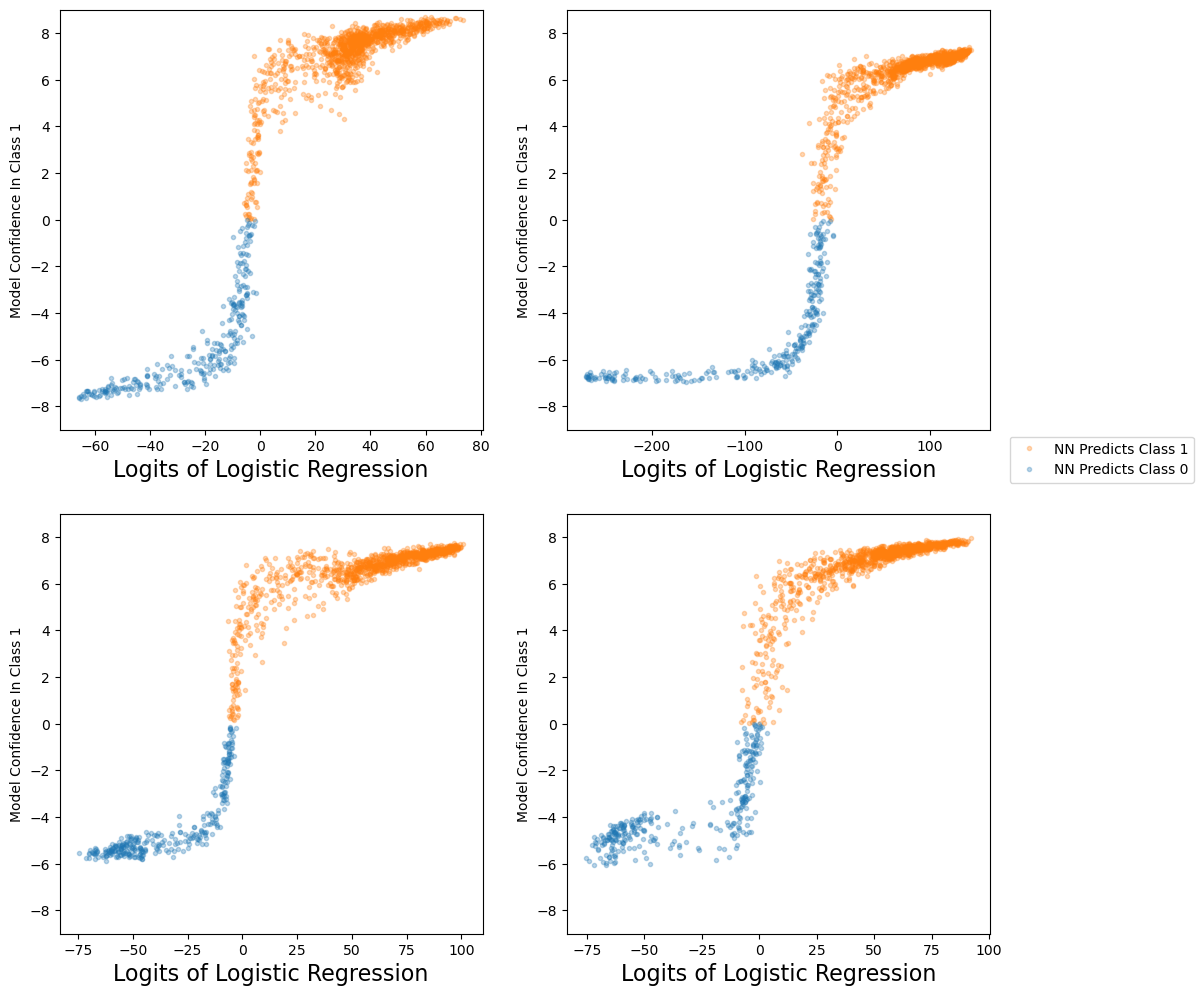

In [67]:
def model_residuals(K1,K1_scaled,NN_y,intercept,PLOT_LOGITS=True):
    class_1_confidence = NN_y[:,1]
    class_1_logits = (class_1_confidence)
    
    model_Y = np.sum(K1_scaled,axis=1) + intercept
    model_Y_logits = sigmoid(model_Y)
    
    X_ = np.mean(K1[:,train_labels==1],axis=1)-np.mean(K1[:,train_labels==0],axis=1)
    X2_ = np.sum(K1_scaled,axis=1) + intercept
    
    #fig=plt.figure(figsize=(6,6))
    
    plt.title("")
    
    
    plt.plot(X2_[logit(class_1_logits)>0],logit(class_1_logits)[logit(class_1_logits)>0],'.',color='tab:orange',alpha=0.3,label='NN Predicts Class 1')
    plt.plot(X2_[logit(class_1_logits)<0],logit(class_1_logits)[logit(class_1_logits)<0],'.',color='tab:blue',alpha=0.3,label='NN Predicts Class 0')
    if PLOT_LOGITS:
        plt.plot(X2_,model_Y,'.',color='k',alpha=0.3,label='LogisticRegression')
    else:
        plt.ylim(-9,9)
    plt.ylabel("Model Confidence In Class 1")
    plt.xlabel('Logits of Logistic Regression',fontsize=16)
    #plt.legend()
    #plt.show()
    
fig = plt.figure(figsize=(12,12))
plt.subplot(2,2,1)
model_residuals(K1_seedless,K1_seedless_scaled,NNseedless_ys,K1_seedless_intercept,False)
plt.subplot(2,2,2)
model_residuals(K1_seed1,K1_seed1_scaled,NN1_ys,K1_seed1_intercept,False)
plt.subplot(2,2,3)
model_residuals(K1_seed2,K1_seed2_scaled,NN2_ys,K1_seed2_intercept,False)
plt.subplot(2,2,4)
model_residuals(K1_seed3,K1_seed3_scaled,NN3_ys,K1_seed3_intercept,False)
plt.legend(bbox_to_anchor=(1.5,1.2))
plt.show()

# More Stuff

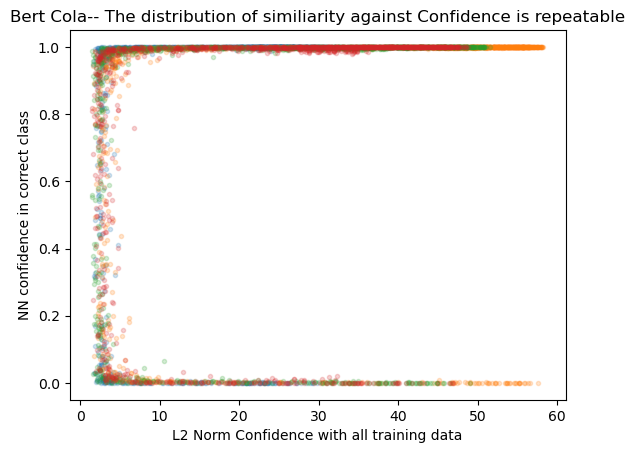

In [68]:
plt.title('Bert Cola-- The distribution of similiarity against Confidence is repeatable')
plt.plot(np.linalg.norm(K1_seedless,2,axis=1),confidences_seedless,'.',alpha=0.2)
plt.plot(np.linalg.norm(K1_seed1,2,axis=1),confidences1,'.',alpha=0.2,color='tab:orange')
plt.plot(np.linalg.norm(K1_seed2,2,axis=1),confidences2,'.',alpha=0.2,color='tab:green')
plt.plot(np.linalg.norm(K1_seed3,2,axis=1),confidences3,'.',alpha=0.2,color='tab:red')
plt.xlabel('L2 Norm Confidence with all training data')
plt.ylabel('NN confidence in correct class')
plt.show()

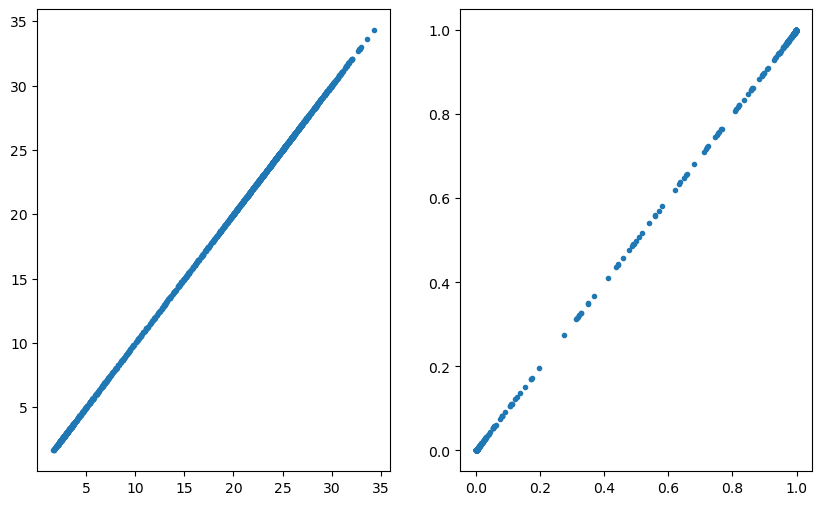

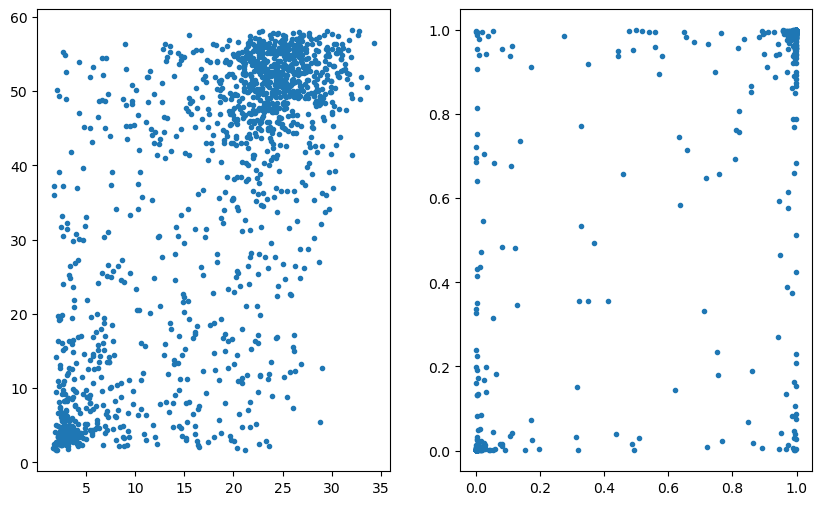

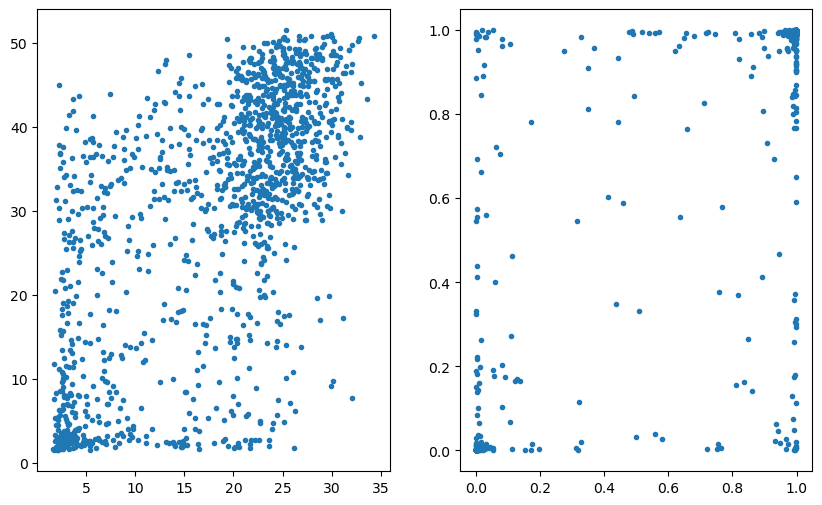

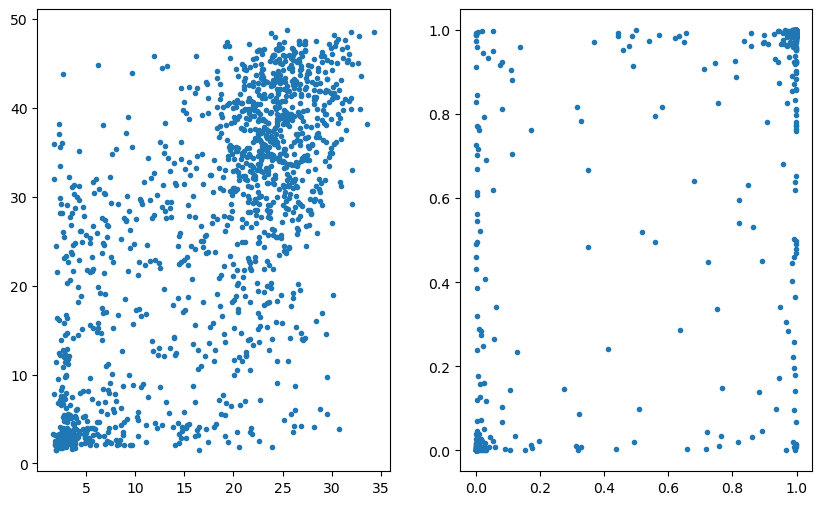

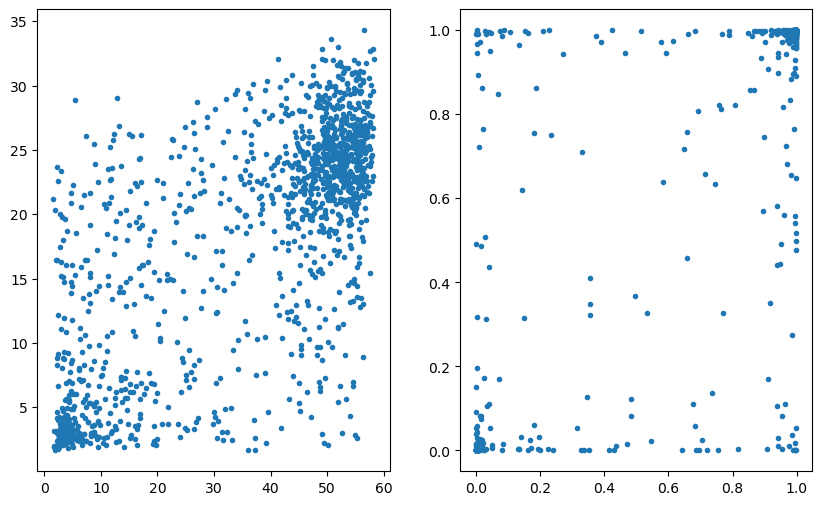

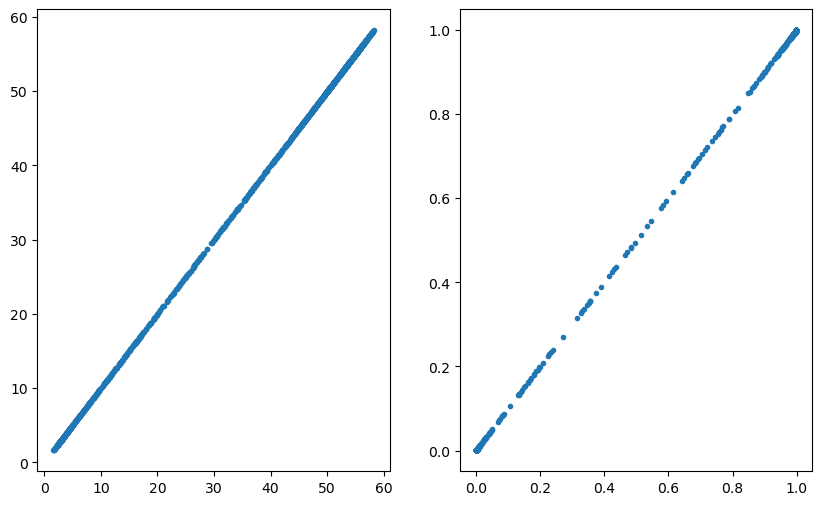

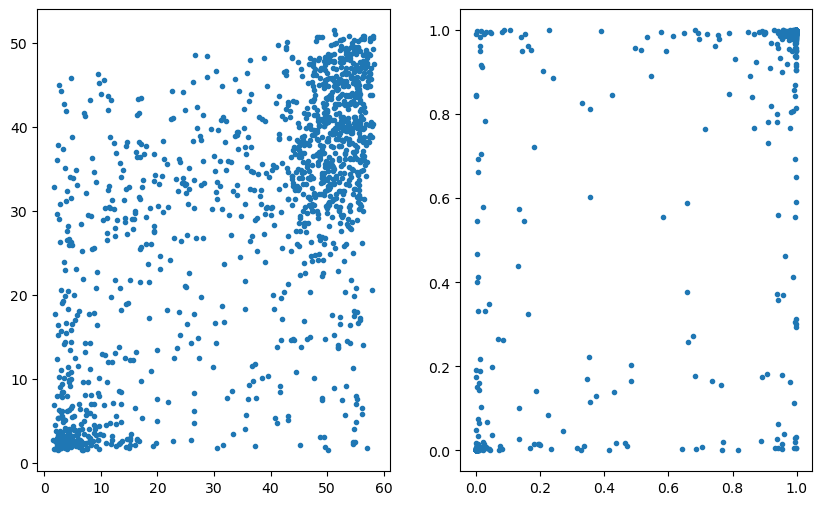

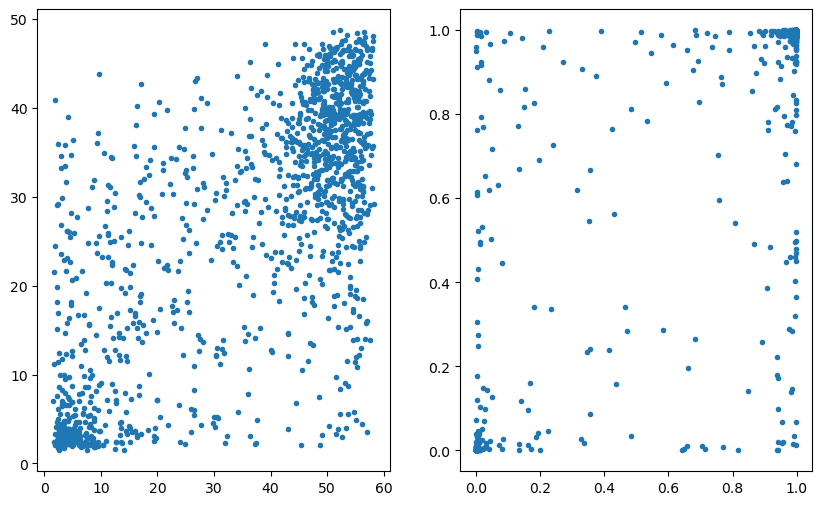

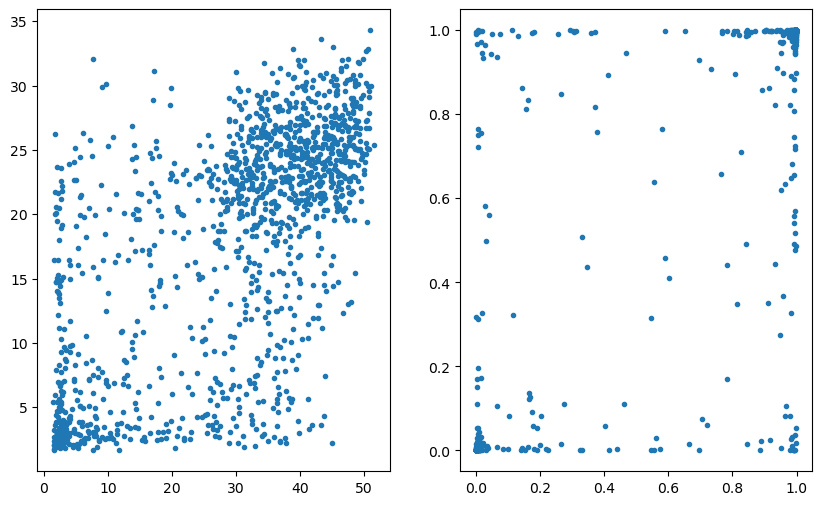

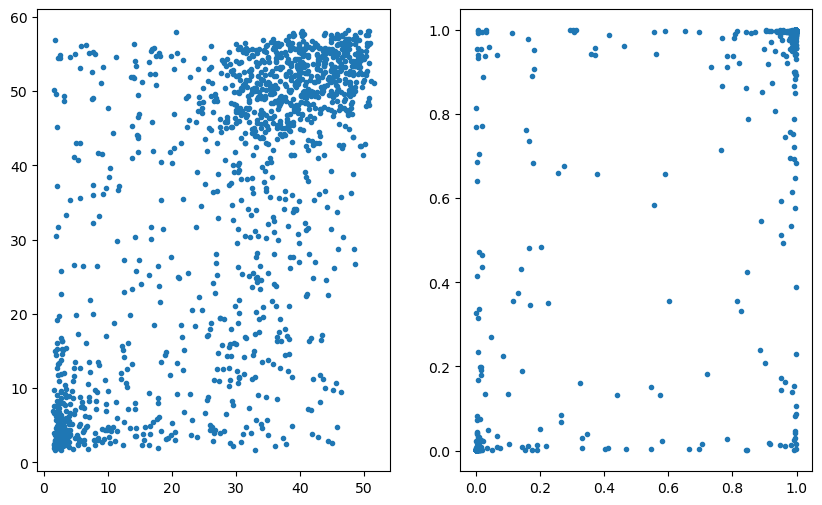

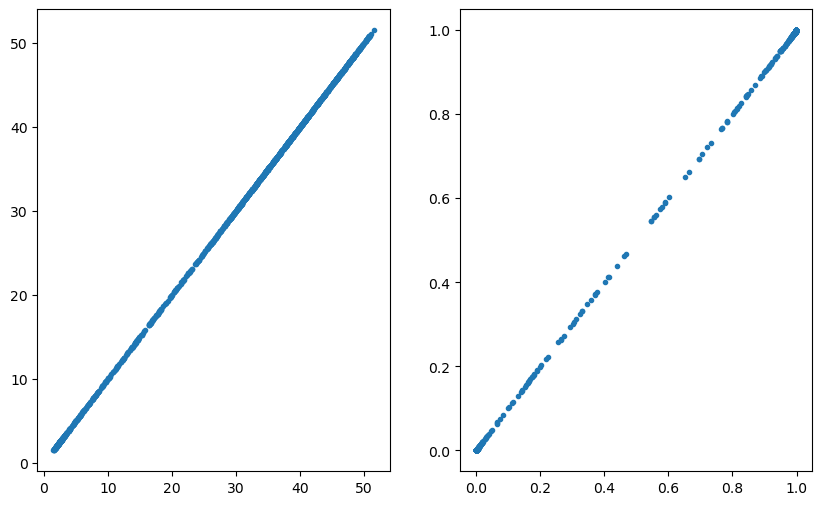

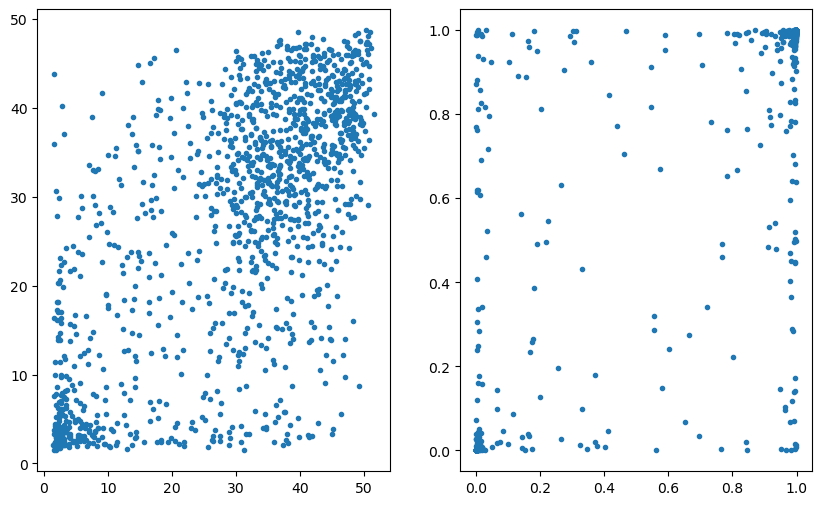

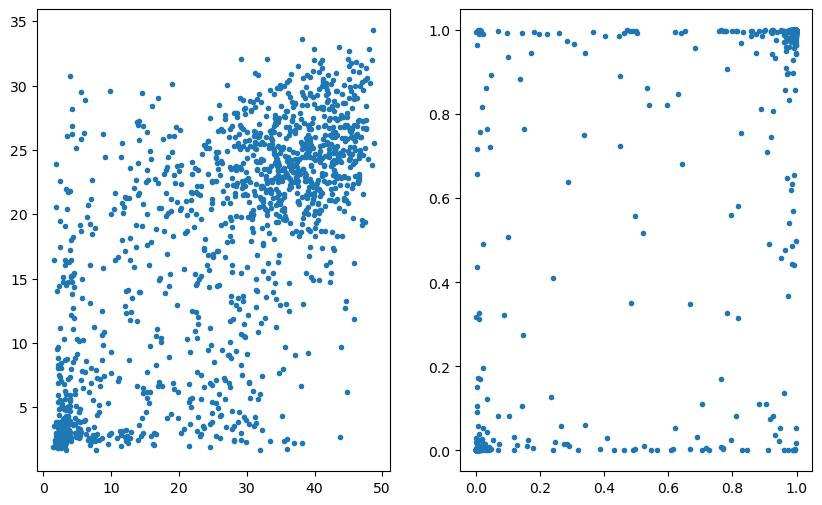

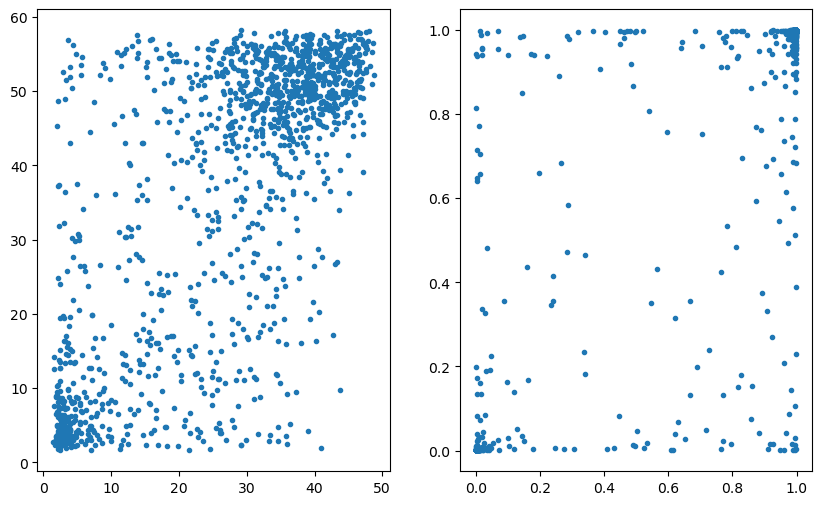

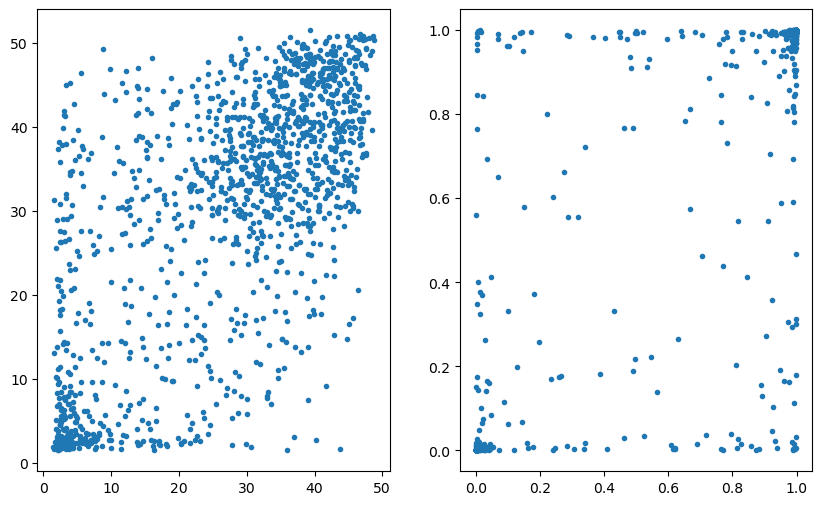

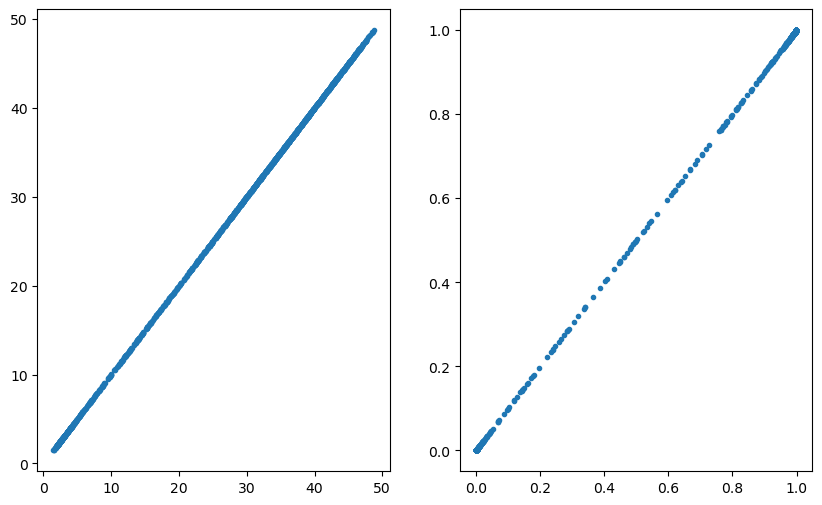

In [69]:
for K_i,Conf_i in zip([K1_seedless,K1_seed1,K1_seed2,K1_seed3],[confidences_seedless,confidences1,confidences2,confidences3]):
    for K_j,Conf_j in zip([K1_seedless,K1_seed1,K1_seed2,K1_seed3],[confidences_seedless,confidences1,confidences2,confidences3]):
        plt.figure(figsize=(10,6))
        plt.subplot(1,2,1)
        plt.plot(np.linalg.norm(K_i,2,axis=1),np.linalg.norm(K_j,2,axis=1),'.')
        plt.subplot(1,2,2)
        plt.plot(Conf_i,Conf_j,'.')
        
        plt.show()


In [70]:
A = np.concatenate([L2_array,confidences_array])

In [71]:
A.shape

(8, 1352)

In [72]:
report = {}
report['K1_seedless_cossim'] = np.linalg.norm(K1_seedless,2,axis=1)
report['K1_seed1_cossim'] = np.linalg.norm(K1_seed1,2,axis=1)
report['K1_seed2_cossim'] = np.linalg.norm(K1_seed2,2,axis=1)
report['K1_seed3_cossim'] = np.linalg.norm(K1_seed3,2,axis=1)

report['confidences_seedless'] = confidences_seedless
report['confidences_seed1'] = confidences1
report['confidences_seed2'] = confidences2
report['confidences_seed3'] = confidences3

report['NN_testys_seedless'] = NNseedless_ys
report['NN_testys_seed1'] = NN1_ys
report['NN_testys_seed2'] = NN2_ys
report['NN_testys_seed3'] = NN3_ys

report['NN_trainys_seedless'] = NNseedless_train_ys
report['NN_trainys_seed1'] = NN1_train_ys
report['NN_trainys_seed2'] = NN2_train_ys
report['NN_trainys_seed3'] = NN3_train_ys


np.save('./../Experiment_results/BERT_cossim.npy',report)

# Look at interesting points where one model is OOD and another is not

In [73]:
interesting_points1 = np.logical_and(np.linalg.norm(K1_seedless,2,axis=1)<5,np.linalg.norm(K1_seed1,2,axis=1)>30)
interesting_points2 = np.logical_and(confidences_seedless<0.6,confidences_seedless>0.4)
interesting_points3 = np.logical_or(confidences1<0.01,confidences1>0.99)

interesting_points = np.where(np.logical_and(np.logical_and(interesting_points1,interesting_points2),interesting_points3))[0]

In [74]:
interesting_points

array([1134])

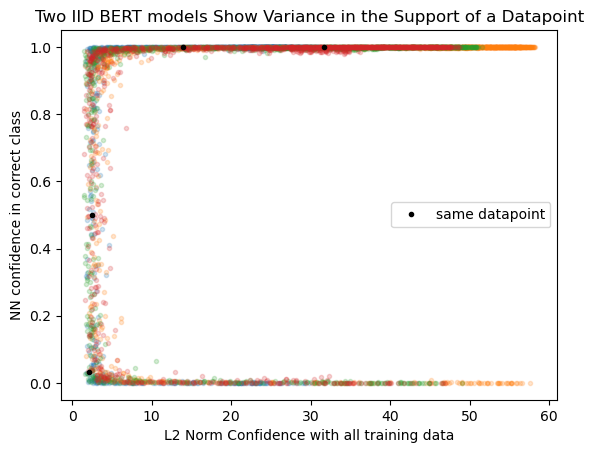

In [75]:
plt.title('Two IID BERT models Show Variance in the Support of a Datapoint')

plt.plot(np.linalg.norm(K1_seedless,2,axis=1),confidences_seedless,'.',alpha=0.2)
plt.plot(np.linalg.norm(K1_seed1,2,axis=1),confidences1,'.',alpha=0.2,color='tab:orange')
plt.plot(np.linalg.norm(K1_seed2,2,axis=1),confidences2,'.',alpha=0.2,color='tab:green')
plt.plot(np.linalg.norm(K1_seed3,2,axis=1),confidences3,'.',alpha=0.2,color='tab:red')

plt.plot(np.linalg.norm(K1_seedless,2,axis=1)[interesting_points],confidences_seedless[interesting_points],'.',color='k',label='same datapoint')
plt.plot(np.linalg.norm(K1_seed1,2,axis=1)[interesting_points],confidences1[interesting_points],'.',color='k')
plt.plot(np.linalg.norm(K1_seed2,2,axis=1)[interesting_points],confidences2[interesting_points],'.',color='k')
plt.plot(np.linalg.norm(K1_seed3,2,axis=1)[interesting_points],confidences3[interesting_points],'.',color='k')

plt.legend()
plt.xlabel('L2 Norm Confidence with all training data')
plt.ylabel('NN confidence in correct class')
plt.show()

In [76]:
np.sqrt(np.square(K1_seed1[1134]).sum())

31.657629

In [77]:
np.sqrt(np.square(K1_seedless[1134]).sum())

2.4512632

# Look at unions

In [71]:
#this is the mask of shared low similarity predictions
union_1 = np.logical_and(np.linalg.norm(K1_seedless,2,axis=1)<5,np.linalg.norm(K1_seed1,2,axis=1)<8)

union_2 = np.logical_and(union_1,np.linalg.norm(K1_seed2,2,axis=1)<5)

union_3 = np.logical_and(union_2,np.linalg.norm(K1_seed3,2,axis=1)<8)

<IPython.core.display.Javascript object>


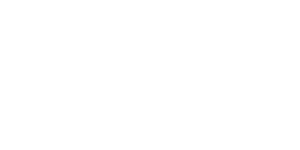

159


In [72]:
%matplotlib notebook
#We want to show the overlap between points that are 

mask = union_1
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter3D(xs=np.linalg.norm(K1_seedless,2,axis=1)[~mask],ys=np.linalg.norm(K1_seed1,2,axis=1)[~mask],zs=(confidences_seedless-confidences1)[~mask],alpha=0.2)
ax.scatter3D(xs=np.linalg.norm(K1_seedless,2,axis=1)[mask],ys=np.linalg.norm(K1_seed1,2,axis=1)[mask],zs=(confidences_seedless-confidences1)[mask],alpha=0.5)
plt.xlabel('Model 1 Cos Sim w/ all training data')
plt.ylabel('Model 2 Cos Sim w/ all training data')
ax.set_zlabel('Model1 conf - Model2 conf')
plt.show()

print(np.sum(mask))

<IPython.core.display.Javascript object>


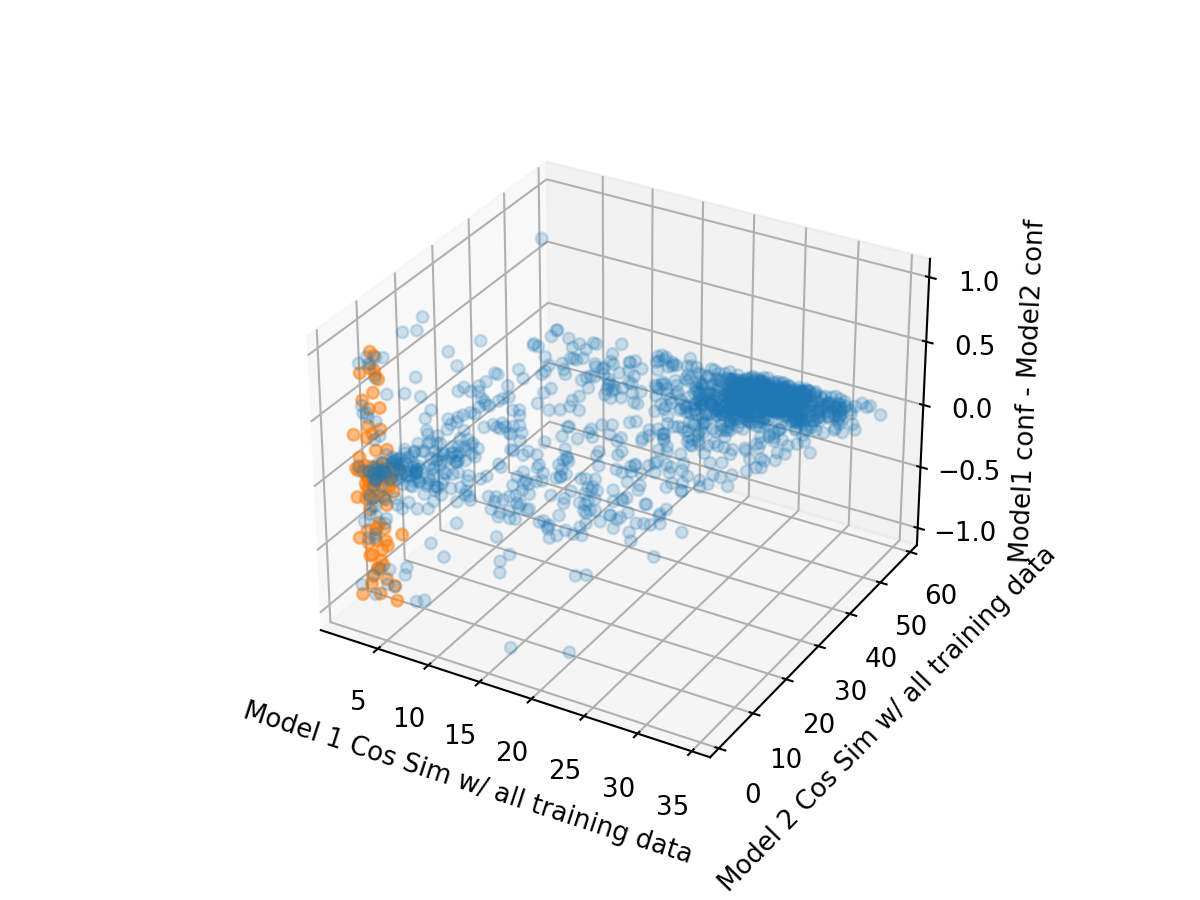

94


In [73]:
%matplotlib notebook
#We want to show the overlap between points that are 

mask = union_2
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter3D(xs=np.linalg.norm(K1_seedless,2,axis=1)[~mask],ys=np.linalg.norm(K1_seed1,2,axis=1)[~mask],zs=(confidences_seedless-confidences1)[~mask],alpha=0.2)
ax.scatter3D(xs=np.linalg.norm(K1_seedless,2,axis=1)[mask],ys=np.linalg.norm(K1_seed1,2,axis=1)[mask],zs=(confidences_seedless-confidences1)[mask],alpha=0.5)
plt.xlabel('Model 1 Cos Sim w/ all training data')
plt.ylabel('Model 2 Cos Sim w/ all training data')
ax.set_zlabel('Model1 conf - Model2 conf')
plt.show()

print(np.sum(mask))

<IPython.core.display.Javascript object>


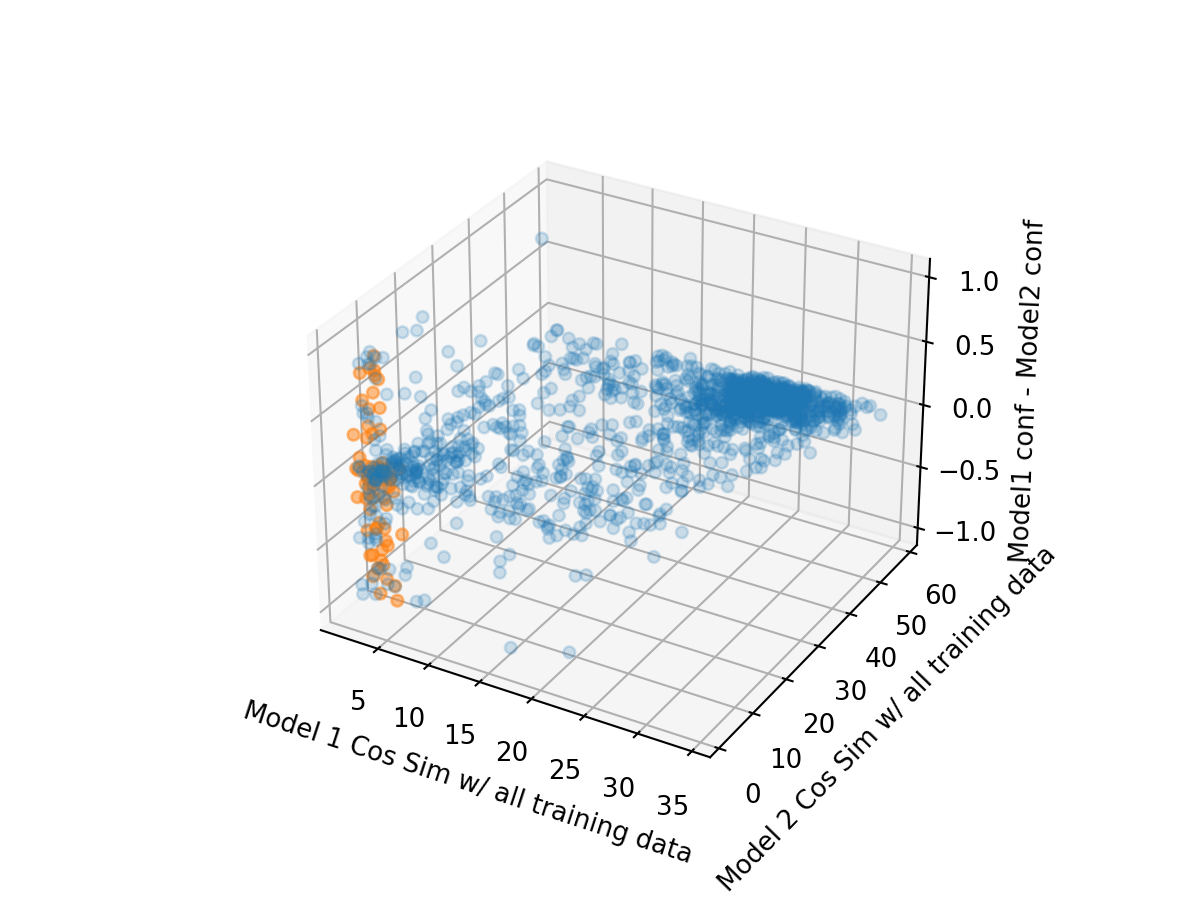

78


In [74]:
#We want to show the overlap between points that are 

mask = union_3
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter3D(xs=np.linalg.norm(K1_seedless,2,axis=1)[~mask],ys=np.linalg.norm(K1_seed1,2,axis=1)[~mask],zs=(confidences_seedless-confidences1)[~mask],alpha=0.2)
ax.scatter3D(xs=np.linalg.norm(K1_seedless,2,axis=1)[mask],ys=np.linalg.norm(K1_seed1,2,axis=1)[mask],zs=(confidences_seedless-confidences1)[mask],alpha=0.5)
plt.xlabel('Model 1 Cos Sim w/ all training data')
plt.ylabel('Model 2 Cos Sim w/ all training data')
ax.set_zlabel('Model1 conf - Model2 conf')
plt.show()

print(np.sum(mask))

# Compare 5 most similar phrases

In [75]:
os.listdir('/rcfs/projects/task0_pmml/BERT/one_gpu_development/')

['BERT_NTK_oneGPU.py',
 '__pycache__',
 'test',
 'BERT_NTK_printlayer.py',
 'MANY_BERT_MODELS',
 'testDDP_additivecomponents_seed2',
 'testDDP_additivecomponents_seed1',
 'NTKs',
 'testDDP_additivecomponents_seed3',
 'testDDP_additivecomponents_seed4',
 'testDDP_additivecomponents_seed5',
 'testDDP_additivecomponents_seed6',
 'testDDP_additivecomponents_seed7',
 'testDDP_additivecomponents_seed8',
 'testDDP_additivecomponents_seed9',
 'BERT_NTK_oneGPU_01.py',
 'NTK_utils.py',
 'testDDP_additivecomponents_unique_seed1',
 'testDDP_additivecomponents_init_seed1']

In [76]:
all_mask_bool = torch.tensor(train_masks,dtype=bool)
validation_mask_bool  =torch.tensor(validation_masks,dtype=bool)

/tmp/ipykernel_203828/3135514208.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  all_mask_bool = torch.tensor(train_masks,dtype=bool)
/tmp/ipykernel_203828/3135514208.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  validation_mask_bool  =torch.tensor(validation_masks,dtype=bool)


In [77]:
N = 5
test_index=1134

device=0
model_seedless.to(device)
model_seedless.eval()
predictions = []
for step,batch in enumerate(validation_dataloader):
        #getting ids,mask,labes for every batch
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
    
        outputs = model_seedless(b_input_ids,  #!!!
                token_type_ids=None, 
                attention_mask=b_input_mask, 
                labels=b_labels)
        
        output = outputs[1]
        y = F.softmax(output,dim=1) #1D
        preds = torch.argmax(y,dim=1)
        predictions.append(preds.cpu().numpy())
        
predictions = np.concatenate(predictions)
    
#name = 'bert.encoder.layer.0.attention.output.dense.weight'
#name = 'bert.encoder.layer.7.output.LayerNorm.bias'
#name = 'bert.encoder.layer.8.output.LayerNorm.bias'
#name = 'bert.pooler.dense.weight'
#name = 'bert.pooler.dense.bias'
name = 'classifier.weight'

# mean_cos_sim = []
# layer_number = []
# layer_num=0

if validation_labels[test_index]==0:
    output=0
else:
    output=1
    
Kend = torch.load('/rcfs/projects/task0_pmml/BERT/testDDP_additivecomponents/{}-{}.pt'.format(name,output))

train_data_index = len(labels) - len(validation_labels)

K0_end = Kend[0:train_data_index,0:train_data_index] #this is the train data gram matrix
K1_end = Kend[train_data_index::,0:train_data_index] #this is the test-data's sim to train data
K2_end = Kend[train_data_index::,train_data_index::]

#convert to cos-sim
K1_end = K1_end / (np.sqrt(np.diagonal(K0_end))[None,:]) / (np.sqrt(np.diagonal(K2_end))[:,None])
K0_end = K0_end / np.sqrt(np.diagonal(K0_end))[None,:] / np.sqrt(np.diagonal(K0_end))[:,None]



indices_N_largest = np.argsort(K1_end[test_index,].cpu().numpy())[-N:]

print(name)
print('Test DataVector: {}; label {}; NN pred {}, NN confidence {:.3f}, L2 sim {:.3f}'.format(tokenizer.decode(validation_inputs[test_index,validation_mask_bool[test_index]]),validation_labels[test_index],predictions[test_index],confidences_seedless[test_index],np.linalg.norm(K1_end[test_index,:],2)))
for i in reversed(range(N)):
    train_index_plot = indices_N_largest[i]
    print('{}th Closest: {}; label {}; Sim {:.3f}'.format(N-i,tokenizer.decode(train_inputs[train_index_plot,all_mask_bool[train_index_plot]]),train_labels[train_index_plot],K1_end[test_index,train_index_plot]))


IndexError: index 1134 is out of bounds for dimension 0 with size 993

In [ ]:
N = 5
test_index=1134


device=0
model_seedless.to(device)
model_seedless.eval()
predictions = []
for step,batch in enumerate(validation_dataloader):
        #getting ids,mask,labes for every batch
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
    
        outputs = model1(b_input_ids,  #!!!
                token_type_ids=None, 
                attention_mask=b_input_mask, 
                labels=b_labels)
        
        output = outputs[1]
        y = F.softmax(output,dim=1) #1D
        preds = torch.argmax(y,dim=1)
        predictions.append(preds.cpu().numpy())
        
predictions = np.concatenate(predictions)
    
#name = 'bert.encoder.layer.0.attention.output.dense.weight'
#name = 'bert.encoder.layer.7.output.LayerNorm.bias'
#name = 'bert.encoder.layer.8.output.LayerNorm.bias'
#name = 'bert.pooler.dense.weight'
#name = 'bert.pooler.dense.bias'
name = 'classifier.weight'

# mean_cos_sim = []
# layer_number = []
# layer_num=0

if validation_labels[test_index]==0:
    output=0
else:
    output=1


Kend = torch.load('/rcfs/projects/task0_pmml/BERT/one_gpu_development/testDDP_additivecomponents_seed1/{}-{}.pt'.format(name,output))

K0_end = Kend[0:train_data_index,0:train_data_index] #this is the train data gram matrix
K1_end = Kend[train_data_index::,0:train_data_index] #this is the test-data's sim to train data
K2_end = Kend[train_data_index::,train_data_index::]

#convert to cos-sim
K1_end = K1_end / (np.sqrt(np.diagonal(K0_end))[None,:]) / (np.sqrt(np.diagonal(K2_end))[:,None])
K0_end = K0_end / np.sqrt(np.diagonal(K0_end))[None,:] / np.sqrt(np.diagonal(K0_end))[:,None]



indices_N_largest = np.argsort(K1_end[test_index,].cpu().numpy())[-N:]

print(name)
print('Test DataVector: {}; label {}; NN pred {}, NN confidence {:.3f}, L2 sim {:.3f}'.format(tokenizer.decode(validation_inputs[test_index,validation_mask_bool[test_index]]),validation_labels[test_index],predictions[test_index],confidences1[test_index],np.linalg.norm(K1_end[test_index,:],2)))
for i in reversed(range(N)):
    train_index_plot = indices_N_largest[i]
    print('{}th Closest: {}; label {}; Sim {:.3f}'.format(N-i,tokenizer.decode(train_inputs[train_index_plot,all_mask_bool[train_index_plot]]),train_labels[train_index_plot],K1_end[test_index,train_index_plot]))


# Instead of looking at one layer at a time, lets look at the most similar according to the NTK

In [ ]:
def NTK_N_closest_training_points(test_index,model,N,K1_end):
    N = 5
    test_index=1134

    predictions = []
    for step,batch in enumerate(validation_dataloader):
            #getting ids,mask,labes for every batch
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)

            outputs = model(b_input_ids,  #!!!
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)

            output = outputs[1]
            y = F.softmax(output,dim=1) #1D
            preds = torch.argmax(y,dim=1)
            predictions.append(preds.cpu().numpy())

    predictions = np.concatenate(predictions)

    if validation_labels[test_index]==0:
        output=0
    else:
        output=1

    indices_N_largest = np.argsort(K1_end[test_index,])[-N:]

    print('Full NTK')
    print('Test DataVector: {}; label {}; NN pred {}, NN confidence {:.3f}, L2 sim {:.3f}'.format(tokenizer.decode(validation_inputs[test_index,validation_mask_bool[test_index]]),validation_labels[test_index],predictions[test_index],confidences1[test_index],np.linalg.norm(K1_end[test_index,:],2)))
    for i in reversed(range(N)):
        train_index_plot = indices_N_largest[i]
        print('{}th Closest: {}; label {}; Sim {:.3f}'.format(N-i,tokenizer.decode(train_inputs[train_index_plot,all_mask_bool[train_index_plot]]),train_labels[train_index_plot],K1_end[test_index,train_index_plot]))

In [ ]:
NTK_N_closest_training_points(1134,model_seedless,5,K1_seedless)
print(' ')
NTK_N_closest_training_points(1134,model1,5,K1_seed1)
print(' ')
NTK_N_closest_training_points(1134,model2,5,K1_seed2)
print(' ')
NTK_N_closest_training_points(1134,model3,5,K1_seed3)
print(' ')


# similarity across layers

In [ ]:
colors_and_names = {}

colors_and_names['query'] = 'tab:red'
colors_and_names['key'] = 'tab:orange'
colors_and_names['value'] = 'tab:green'
colors_and_names['output.dense'] = 'tab:brown'
colors_and_names['intermediate.dense'] = 'tab:purple'
colors_and_names['output.LayerNorm'] = 'k'

In [ ]:
mean_cos_sim = []
layer_number = []
layer_num=0
for i,(name,param) in tqdm(enumerate(model_seedless.named_parameters())):
    layer_mean = []
    #for output in range(2):
    output=1
    Kend = torch.load('/rcfs/projects/task0_pmml/BERT/testDDP_additivecomponents/{}-{}.pt'.format(name,output))

    K0_end = Kend[0:train_data_index,0:train_data_index] #this is the train data gram matrix
    K1_end = Kend[train_data_index::,0:train_data_index] #this is the test-data's sim to train data
    K2_end = Kend[train_data_index::,train_data_index::]

    #convert to cos-sim
    K1_end = K1_end / (np.sqrt(np.diagonal(K0_end))[None,:]) / (np.sqrt(np.diagonal(K2_end))[:,None])
    K0_end = K0_end / np.sqrt(np.diagonal(K0_end))[None,:] / np.sqrt(np.diagonal(K0_end))[:,None]

    layer_mean.append(np.linalg.norm(K1_end[test_index,].cpu().numpy(),2,axis=0))
        
    #layer_mean = np.mean(np.concatenate(layer_mean))
    mean_cos_sim.append(layer_mean)
    layer_num+=1
    layer_number.append(layer_num)

In [ ]:
mean_cos_sim_test

In [ ]:
fig = plt.figure(figsize=(8,8))

for i,(name,param) in enumerate(model_seedless.named_parameters()):
#     if 'bias' in name:
#         continue
    plotted=False
    for key in list(colors_and_names.keys()):
        if key in name:
            plt.plot(layer_number[i],mean_cos_sim_test[i],'.',color=colors_and_names[key])
            plotted=True
    if not(plotted):
        plt.plot(layer_number[i],mean_cos_sim_test[i],'.',color='tab:blue')
        

for key in list(colors_and_names.keys()):
    plt.plot([-1,],[-1,],'.',color=colors_and_names[key],label=key)
plt.plot([-1,],[-1,],'.',color='tab:blue',label='other')
plt.legend(loc='upper left')
plt.xlim(-0.1,201)
#plt.ylim(-0.01,1.0)
    
plt.xlabel('Layer Depth')
plt.ylabel('Train Vector Mean Cos Sim to all Training Vectors of the Same Class')
plt.title('Model1 Train Datapoint Feature Extraction Similiarity to Same Class Colored by Layer Type')
plt.show()

# mean_cos_sim

In [ ]:
mean_cos_sim2 = []
layer_number2 = []
layer_num=0
for i,(name,param) in tqdm(enumerate(model1.named_parameters())):
    layer_mean = []
    #for output in range(2):
    output=1
    Kend = torch.load('/rcfs/projects/task0_pmml/BERT/one_gpu_development/testDDP_additivecomponents_seed1/{}-{}.pt'.format(name,output))

    K0_end = Kend[0:train_data_index,0:train_data_index] #this is the train data gram matrix
    K1_end = Kend[train_data_index::,0:train_data_index] #this is the test-data's sim to train data
    K2_end = Kend[train_data_index::,train_data_index::]

    #convert to cos-sim
    K1_end = K1_end / (np.sqrt(np.diagonal(K0_end))[None,:]) / (np.sqrt(np.diagonal(K2_end))[:,None])
    K0_end = K0_end / np.sqrt(np.diagonal(K0_end))[None,:] / np.sqrt(np.diagonal(K0_end))[:,None]

    layer_mean.append(np.linalg.norm(K1_end[test_index,].cpu().numpy(),2,axis=0))
        
    #layer_mean = np.mean(np.concatenate(layer_mean))
    mean_cos_sim2.append(layer_mean)
    layer_num+=1
    layer_number2.append(layer_num)

In [ ]:
fig = plt.figure(figsize=(8,8))

for i,(name,param) in enumerate(model1.named_parameters()):
#     if 'bias' in name:
#         continue
    plotted=False
    for key in list(colors_and_names.keys()):
        if key in name:
            plt.plot(layer_number[i],mean_cos_sim2[i],'.',color=colors_and_names[key])
            plotted=True
    if not(plotted):
        plt.plot(layer_number[i],mean_cos_sim[i],'.',color='tab:blue')
        

for key in list(colors_and_names.keys()):
    plt.plot([-1,],[-1,],'.',color=colors_and_names[key],label=key)
plt.plot([-1,],[-1,],'.',color='tab:blue',label='other')
plt.legend(loc='upper left')
plt.xlim(-0.1,201)
#plt.ylim(-0.01,1.0)
    
plt.xlabel('Layer Depth')
plt.ylabel('Train Vector Mean Cos Sim to all Training Vectors of the Same Class')
plt.title('Model2 Train Datapoint Feature Extraction Similiarity to Same Class Colored by Layer Type')
plt.show()